# Libraries

In [ ]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
import statsmodels.api as sm
from autograd import grad
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from termcolor import colored
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.svm import LinearSVC
from termcolor import colored
from datetime import datetime
import os
import similaritymeasures
import tslearn
from tslearn.metrics import dtw
from scipy.spatial.distance import directed_hausdorff
from frechetdist import frdist
import trjtrypy as tt
from trjtrypy.distances import d_Q
from trjtrypy.distances import d_Q_pi
import trjtrypy.visualizations as vs
from scipy.spatial import distance
from trjtrypy.featureMappings import curve2vec

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler
import torchvision.transforms as T

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Read Data

In [ ]:
I = glob.glob('T-Drive/**/*.txt', recursive=True)

In [ ]:
# runtime about 35s
Start_time = time.time()
J = [0] * len(I)

for i in range(len(I)):
    for j in range(len(I)):
        if int(I[j][28:-4]) == i+1:
            J[i] = I[j]
print('total time =', time.time() - Start_time)

total time = 47.05940508842468


In [ ]:
taxi_id = np.array([J[i][28:-4] for i in range(len(J))])
I = np.sort(list(map(int, taxi_id)))
True in I == list(map(int, taxi_id)) # so the taxi ids are nn.arange(len(J))

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
len(J)

10357

In [ ]:
# create 'daysDate' function to convert start and end time to a float number of days

def days_date(time_str):
    date_format = "%Y-%m-%d %H:%M:%S"
    current = datetime.strptime(time_str, date_format)
    date_format = "%Y-%m-%d"
    bench = datetime.strptime('2006-12-30', date_format)
    no_days = current - bench
    delta_time_days = no_days.days + current.hour / 24.0 + current.minute / (24. * 60.) + current.second / (24. * 3600.)
    return delta_time_days

days_date = np.vectorize(days_date)
float1 = np.vectorize(float)

In [ ]:
def read_file(file_name):
    data = []
    f = open(file_name, "r")
    for line in f:
        item = line.strip().split(",")
        if len(item) ==4:
            data.append(np.asarray(item[1:]))
    data = np.array(data)
    return data

### Remove stationary points

In [ ]:
def remove_segments(traj): # removes stationary points
    p2 = traj[:,1:][1:]
    p1 = traj[:,1:][:-1]
    L = ((p2-p1)*(p2-p1)).sum(axis =1)
    I = np.where(L>1e-16)[0]
    return traj[I]

### In data1 below:
    (1) there is no stationary points
    (2) there is no trajectories with less than 1 or more than 200 waypoints

In [ ]:
# runtime about 350s
Start_time = time.time()
T = len(J)
data1 = [] 
taxi_ids = []
for i in range(T):
    a = read_file(J[i])
    if len(a) > 1000:  
        a[:,0] = days_date(a[:,0])
        a = float1(a)
        data1.append(remove_segments(a)) 
        taxi_ids.append(i)

taxi_ids = np.array(taxi_ids)   
data1 = np.array(data1, dtype='object')
I = np.where(np.array([len(data1[i]) for i in range(len(data1))]) > 0)[0]
data1 = data1[I]
taxi_ids = np.array(taxi_ids[I], dtype='object')
print('total time =', time.time() - Start_time)
print("len(data1) =", len(data1))
print("selected taxi_ids: \n", taxi_ids)

total time = 364.23628425598145
len(data1) = 6611
selected taxi_ids: 
 [1 2 9 ... 10339 10350 10353]


In [ ]:
def partition(trajectory, threshold=20):
    trajectories = []
    a = 24 * 60 * (trajectory[-1][0] - trajectory[0][0])
    if a <= threshold:
        return np.array(trajectory.reshape(1, len(trajectory), 3))
    else: 
        i = 0
        while a > threshold:
            j = i + 0
            val = 0
            while val < threshold: 
                if i < len(trajectory) - 1:
                    temp = val + 0
                    val += 24 * 60 * (trajectory[:,0][1:][i] - trajectory[:,0][:-1][i])
                    i += 1
                else: 
                    break
            if len(trajectory[j:i-1]) > 0:
                trajectories.append(trajectory[j:i-1])
            a = a - val
        if len(trajectory[i:]) > 0:
            trajectories.append(trajectory[i:])
    trajectories = np.array(trajectories, dtype='object')
    return trajectories

### In data3 below 
    1) any taxi has between 100 and 200 trajectories
    2) in each taxi dataset any trajectory has less than 20 minutes time

In [ ]:
Start_time = time.time()
data3 = []
idxs = []
for i in range(len(data1)):
    D = []
    A = partition(data1[i], threshold=20)
    for j in range(len(A)):
        if ((len(A[j]) >= 10) and (len(A[j]) <= 200)):
            D.append(A[j])
    if (len(D) >= 100 and len(D) <= 200):
        data3.append(np.array(D, dtype='object'))
        idxs.append(i)

taxi_idxs = taxi_ids[idxs]
data3 = np.array(data3, dtype='object')
taxi_idxs = np.array(taxi_idxs)

print('total time =', time.time() - Start_time)
print("len(data3) =", len(data3))
print("len(taxi_idxs) =", len(taxi_idxs))

A = np.array([len(data3[i]) for i in range(len(data3))])
print(colored(f"min and max length of selected users: {min(A), max(A)}", "green"))

print("number of selected users:", len(data3))
print("idxs: \n", idxs)
print(colored(f"selected taxi ids: \n {taxi_idxs}", "blue"))

total time = 25.952110052108765
len(data3) = 433
len(taxi_idxs) = 433
min and max length of selected users: (100, 200)
number of selected users: 433
idxs: 
 [2, 4, 16, 17, 18, 75, 76, 97, 137, 333, 504, 505, 542, 558, 559, 561, 571, 572, 573, 587, 595, 597, 601, 612, 620, 636, 667, 727, 753, 897, 910, 923, 926, 933, 939, 940, 942, 945, 947, 972, 989, 1007, 1034, 1036, 1047, 1060, 1063, 1066, 1067, 1069, 1076, 1161, 1174, 1181, 1189, 1190, 1195, 1197, 1208, 1210, 1212, 1215, 1217, 1218, 1224, 1229, 1231, 1240, 1244, 1246, 1249, 1250, 1257, 1269, 1280, 1292, 1294, 1299, 1300, 1304, 1307, 1310, 1405, 1421, 1422, 1423, 1429, 1435, 1439, 1440, 1443, 1469, 1477, 1488, 1490, 1499, 1519, 1531, 1540, 1544, 1551, 1562, 1618, 1622, 1642, 1643, 1670, 1674, 1676, 1677, 1679, 1680, 1690, 1701, 1702, 1708, 1717, 1745, 1847, 1849, 1855, 1858, 1859, 1860, 1865, 1881, 1882, 1883, 1894, 1895, 1897, 1902, 1907, 1914, 1929, 2025, 2059, 2070, 2126, 2127, 2237, 2299, 2300, 2349, 2364, 2374, 2375, 2378, 2437,

In [ ]:
data = data3
Min = np.min([np.min([np.min(data[i][j][:,1:], 0) for j in range(len(data[i]))], 0) for i in range(len(data))], 0)
Max = np.max([np.max([np.max(data[i][j][:,1:], 0) for j in range(len(data[i]))], 0) for i in range(len(data))], 0)
Mean = np.mean([np.mean([np.mean(data[i][j][:,1:], 0) for j in range(len(data[i]))], 0) for i in range(len(data))], 0)
Std = np.std([np.std([np.std(data[i][j][:,1:], 0) for j in range(len(data[i]))], 0) for i in range(len(data))], 0)
Min, Mean, Max, Std

(array([0., 0.]),
 array([116.40009395,  39.92449853]),
 array([127.79612,  53.0025 ]),
 array([0.97710344, 0.33774151]))

In [ ]:
pairs = []
for i in range(len(data)-1):
    for j in range(i+1, len(data)):
        pairs.append([i,j])
pairs = np.array(pairs)
print(len(pairs))

93528


In [ ]:
#I = np.arange(len(pairs))
#np.random.shuffle(I)
#pairs_100 = pairs[I[:100]]
# we did above and chose the following pairs
pairs_100 = np.array([[ 87, 166], [161, 396], [370, 425], [209, 421], [ 84, 278], 
                      [ 24,  95], [ 72, 249], [358, 419], [ 86, 382], [241, 297],
                      [315, 363], [273, 335], [118, 270], [323, 430], [ 30, 431],
                      [111, 297], [ 17, 103], [191, 210], [179, 240], [ 53, 139],
                      [156, 240], [128, 412], [  8, 166], [ 96,  98], [270, 303],
                      [160, 319], [ 17,  41], [ 46, 381], [165, 216], [  8, 148],
                      [231, 287], [293, 426], [131, 264], [136, 271], [ 69, 137],
                      [120, 139], [111, 261], [ 13, 114], [138, 291], [ 31, 414], 
                      [252, 276], [ 38, 126], [ 31, 243], [382, 417], [240, 262],
                      [ 45,  49], [313, 359], [107, 206], [212, 243], [ 91, 383],
                      [118, 402], [ 31, 355], [ 74, 365], [110, 132], [136, 330],
                      [326, 376], [ 28, 128], [258, 302], [193, 256], [ 48, 151],
                      [255, 309], [340, 391], [ 90, 216], [341, 400], [ 45, 296], 
                      [206, 370], [184, 379], [248, 343], [ 16, 271], [245, 401],
                      [ 25, 130], [ 15, 430], [ 20, 285], [362, 385], [192, 343], 
                      [111, 410], [400, 414], [116, 185], [ 48, 202], [ 85, 234], 
                      [281, 392], [318, 320], [ 85, 417], [390, 427], [357, 428], 
                      [150, 189], [ 40, 343], [173, 249], [ 38, 399], [121, 393], 
                      [152, 316], [  0, 141], [ 24, 397], [255, 424], [ 92, 330], 
                      [121, 245], [ 78, 240], [ 68, 255], [ 21, 288], [278, 399]])

In [ ]:
print(pairs_100.tolist())

[[87, 166], [161, 396], [370, 425], [209, 421], [84, 278], [24, 95], [72, 249], [358, 419], [86, 382], [241, 297], [315, 363], [273, 335], [118, 270], [323, 430], [30, 431], [111, 297], [17, 103], [191, 210], [179, 240], [53, 139], [156, 240], [128, 412], [8, 166], [96, 98], [270, 303], [160, 319], [17, 41], [46, 381], [165, 216], [8, 148], [231, 287], [293, 426], [131, 264], [136, 271], [69, 137], [120, 139], [111, 261], [13, 114], [138, 291], [31, 414], [252, 276], [38, 126], [31, 243], [382, 417], [240, 262], [45, 49], [313, 359], [107, 206], [212, 243], [91, 383], [118, 402], [31, 355], [74, 365], [110, 132], [136, 330], [326, 376], [28, 128], [258, 302], [193, 256], [48, 151], [255, 309], [340, 391], [90, 216], [341, 400], [45, 296], [206, 370], [184, 379], [248, 343], [16, 271], [245, 401], [25, 130], [15, 430], [20, 285], [362, 385], [192, 343], [111, 410], [400, 414], [116, 185], [48, 202], [85, 234], [281, 392], [318, 320], [85, 417], [390, 427], [357, 428], [150, 189], [40, 3

In [ ]:
taxi_ids_selected = list(set(pairs_100.reshape(200,)))
print("Chosen Users: \n", taxi_ids_selected)

Chosen Users: 
 [0, 8, 13, 15, 16, 17, 20, 21, 24, 25, 28, 30, 31, 38, 40, 41, 45, 46, 48, 49, 53, 68, 69, 72, 74, 78, 84, 85, 86, 87, 90, 91, 92, 95, 96, 98, 103, 107, 110, 111, 114, 116, 118, 120, 121, 126, 128, 130, 131, 132, 136, 137, 138, 139, 141, 148, 150, 151, 152, 156, 160, 161, 165, 166, 173, 179, 184, 185, 189, 191, 192, 193, 202, 206, 209, 210, 212, 216, 231, 234, 240, 241, 243, 245, 248, 249, 252, 255, 256, 258, 261, 262, 264, 270, 271, 273, 276, 278, 281, 285, 287, 288, 291, 293, 296, 297, 302, 303, 309, 313, 315, 316, 318, 319, 320, 323, 326, 330, 335, 340, 341, 343, 355, 357, 358, 359, 362, 363, 365, 370, 376, 379, 381, 382, 383, 385, 390, 391, 392, 393, 396, 397, 399, 400, 401, 402, 410, 412, 414, 417, 419, 421, 424, 425, 426, 427, 428, 430, 431]


In [ ]:
print("Chosen Users From Data:")
taxi_idxs[taxi_ids_selected] + 1

Chosen Users From Data:


array([10, 251, 817, 820, 839, 841, 875, 877, 919, 947, 1112, 1327, 1350,
       1378, 1439, 1466, 1557, 1563, 1567, 1570, 1725, 1825, 1830, 1847,
       1909, 1950, 2127, 2128, 2138, 2146, 2157, 2193, 2205, 2240, 2274,
       2313, 2454, 2550, 2566, 2567, 2594, 2617, 2862, 2876, 2880, 2909,
       2924, 2927, 2938, 2943, 3142, 3154, 3259, 3260, 3511, 3772, 3866,
       3872, 3896, 3939, 3953, 3954, 3965, 3968, 4312, 4393, 4415, 4452,
       4527, 4580, 4582, 4590, 4730, 4830, 4854, 4875, 4889, 4969, 5415,
       5605, 5896, 5921, 5970, 6168, 6274, 6286, 6361, 6427, 6464, 6569,
       6611, 6623, 6652, 6790, 6834, 6876, 6899, 6908, 6970, 6997, 7008,
       7016, 7133, 7139, 7193, 7199, 7347, 7376, 7411, 7434, 7467, 7469,
       7624, 7653, 7674, 7790, 7840, 7971, 8063, 8260, 8275, 8367, 8654,
       8672, 8676, 8696, 8731, 8736, 8764, 8833, 9186, 9241, 9275, 9278,
       9290, 9316, 9354, 9356, 9368, 9395, 9438, 9468, 9481, 9500, 9513,
       9525, 9788, 9812, 9837, 9946, 10012, 10082,

In [ ]:
data = data[taxi_ids_selected]
data.shape

(159,)

# Classifiers

In [ ]:
CC = [100, 100, 1000]
number_estimators = 50

clf1 = [make_pipeline(LinearSVC(dual=False, C=CC[0], tol=1e-5, 
                               class_weight ='balanced', max_iter=1000)), 
        "SVM, LinearSVC, C = "+str(CC[0])]
clf2 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[1], kernel='rbf', gamma='auto', max_iter=200000)),
        "Gaussian SVM, C="+str(CC[1])+", gamma=auto"]
clf3 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[2], kernel='poly', degree=3, max_iter=400000)),
        "Poly kernel SVM, C="+str(CC[2])+", deg=auto"]
clf4 = [DecisionTreeClassifier(), "Decision Tree"]
clf5 = [RandomForestClassifier(n_estimators=number_estimators), 
         "RandomForestClassifier, n="+str(number_estimators)]
clf6 = [KNeighborsClassifier(n_neighbors=5), "KNN"]
clf7 = [LogisticRegression(solver='lbfgs'), "Logistic Regression"]

clf = [clf1, clf2, clf3, clf4, clf5, clf6, clf7]

classifs = [item[0] for item in clf]
keys = [item[1] for item in clf]

# Chosen 5 pairs of Taxies

In [ ]:
pairs_final = [[50, 94], [83, 144], [25, 80], [43, 53], [12, 82]]
pairs_final

[[50, 94], [83, 144], [25, 80], [43, 53], [12, 82]]

# Experiments on 5 chosen pairs start from here

# Plot 50 trajectory from each user

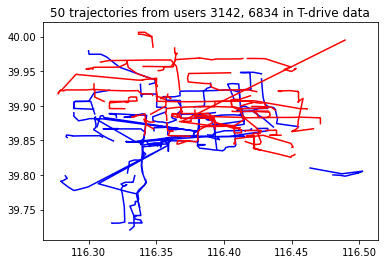

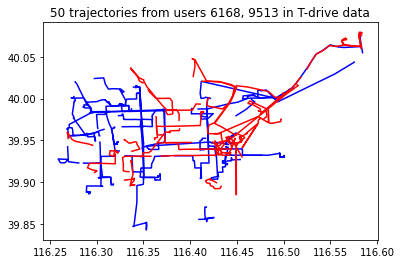

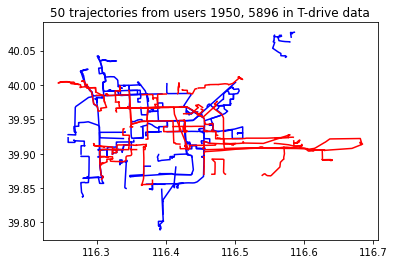

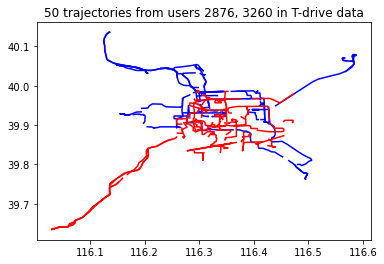

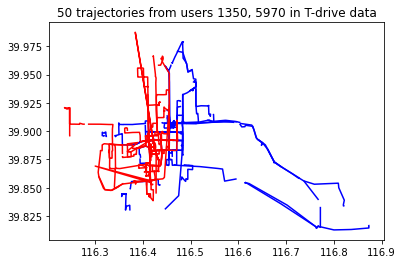

In [ ]:
pairs_from_data = [(3142, 6834), (6168, 9513), (1950, 5896), (2876, 3260), (1350, 5970)]
pairs_final = [[50, 94], [83, 144], [25, 80], [43, 53], [12, 82]]
path = '/Users/hasan/Desktop/Anaconda/Research/Pictures for 2ed paper/'

for k in range(len(pairs_final)):
    m, n = pairs_final[k]
    r, s = pairs_from_data[k]
    for i in range(10,60):
        plt.plot(data[m][i][:,0], data[m][i][:,1], color='blue')
    for i in range(10,60):
        plt.plot(data[n][i][:,0], data[n][i][:,1], color='red')
    plt.title(f'50 trajectories from users {r}, {s} in T-drive data')
    plt.savefig(path+f'Taxi-pairs {pairs_from_data[k]}.png', bbox_inches='tight', 
                dpi=200)
    plt.show()

# Get length and width of the box containig pairs

In [ ]:
pairs_from_data = [(3142, 6834), (6168, 9513), (1950, 5896), (2876, 3260), (1350, 5970)]
pairs_final = [[50, 94], [83, 144], [25, 80], [43, 53], [12, 82]]

for k in range(len(pairs_final)):
    m, n = pairs_final[k]
    r, s = pairs_from_data[k]
    min_x, min_y = np.min((np.min([np.min(data[m][i], axis=0) for i in range(len(data[m]))], axis=0), 
           np.min([np.min(data[n][i], axis=0) for i in range(len(data[n]))], axis=0)), axis=0)

    max_x, max_y = np.max((np.max([np.max(data[m][i], axis=0) for i in range(len(data[m]))], axis=0), 
                   np.max([np.max(data[n][i], axis=0) for i in range(len(data[n]))], axis=0)), axis=0)

    print(f"length and width of pair {r, s}:", np.round(max_x - min_x, decimals=2), 
          np.round(max_y - min_y, decimals=2))
    print("len(data[m]), len(data[n]):", len(data[m]), len(data[n]))
    print()

length and width of pair (3142, 6834): 14.97 16.64
len(data[m]), len(data[n]): 143 116

length and width of pair (6168, 9513): 0.97 0.83
len(data[m]), len(data[n]): 143 119

length and width of pair (1950, 5896): 1.16 1.31
len(data[m]), len(data[n]): 140 123

length and width of pair (2876, 3260): 0.81 0.51
len(data[m]), len(data[n]): 100 132

length and width of pair (1350, 5970): 0.76 0.48
len(data[m]), len(data[n]): 132 127



## KNN classification with 10 distances: (done)
    discret_frechet, hausdorff, dtw_tslearn, soft-dtw, fastdtw, 'lcss', sspd, edr, erp, d_Q_pi

In [ ]:
import numpy as np
import time
import pandas as pd
import random
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import traj_dist.distance as tdist
import pickle
import tslearn
from tslearn.metrics import dtw as dtw_tslearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from trjtrypy.distances import d_Q_pi
from sdtw import SoftDTW
from termcolor import colored
from KNN_Class import KNN

In [ ]:
metrics = ['discret_frechet', 'hausdorff', dtw_tslearn, SoftDTW, fastdtw, 'lcss', 'sspd',
           'edr', 'erp', 'd_Q_pi']

path = 'Calculated Distance Matrices for KNN-T-drive/'

train_test_mean_median_std_KNN_errors = []
test_KNN_errors = []
std_KNN_errors = []

for pair in pairs_final:
    print('pair =', pair)
    temp = []
    for i in range(len(metrics)):
        KNN_class = KNN(data[pair[0]], data[pair[1]], metric=metrics[i], gamma=1e-14, 
                        eps_edr=0.005, eps_lcss=0.005, Q_size=20, Q=None, p=2, 
                        path=path+str(metrics[i])+'-'+str(pair), 
                        test_size=0.3, n_neighbors=5, num_trials=50, pair=[0,1])

        KNN_class.write_matrix_to_csv()
        A = KNN_class.KNN_average_error()
        temp.append(A[1:])        
        print(i, A[0])
        print("==========================================================================")
    
    train_test_mean_median_std_KNN_errors.append(temp)
    test_KNN_errors.append(np.array(temp)[:,1])
    std_KNN_errors.append(np.array(temp)[:,3])
    print(colored("******************************************************************************", 'red'))
    print(colored("******************************************************************************", 'red'))
    print(colored("******************************************************************************", 'red'))
    
train_test_mean_median_std_KNN_errors = np.array(train_test_mean_median_std_KNN_errors)
test_KNN_errors = np.array(test_KNN_errors)
std_KNN_errors = np.array(std_KNN_errors)

list_test_error = list(np.round(np.mean(test_KNN_errors, 0), decimals=4))
list_std_error = list(np.round(np.mean(std_KNN_errors, 0), decimals=4))
print(colored(f'average test errors of 5 pairs: \n {list_test_error}', 'magenta'))
print(colored(f'average stds of 5 pairs: \n {list_std_error}', 'yellow'))


pair = [50, 94]
num_trials = 50
total time = 1.4788641929626465
0                           Classifier  Train Error    Mean  Median     Std
1  KNN; discret_frechet; pair [0, 1]       0.2556  0.3813  0.3846  0.0468
num_trials = 50
total time = 1.7621359825134277
1                     Classifier  Train Error    Mean  Median     Std
1  KNN; hausdorff; pair [0, 1]       0.2539  0.3887  0.3974  0.0501
num_trials = 50
total time = 1.4673552513122559
2                                           Classifier  Train Error    Mean  \
1  KNN; <function dtw at 0x7f906006c7a0>; pair [0...       0.2379  0.3682   

   Median     Std  
1   0.359  0.0482  
num_trials = 50
total time = 1.4360880851745605
3                                           Classifier  Train Error    Mean  \
1  KNN; <class 'sdtw.soft_dtw.SoftDTW'>; pair [0, 1]       0.2331  0.3636   

   Median     Std  
1  0.3654  0.0464  
num_trials = 50
total time = 1.4583709239959717
4                                       Classifier  Train Erro

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/traj_dist-1.1-py3.7-macosx-10.9-x86_64.egg/traj_dist/distance.py:552: UserWarning: g parameter should be specified for metric erp. Default is 
  warnings.warn("g parameter should be specified for metric erp. Default is ")


num_trials = 50
total time = 1.4421899318695068
8               Classifier  Train Error    Mean  Median     Std
1  KNN; erp; pair [0, 1]       0.2119  0.3305  0.3269  0.0487
num_trials = 50
total time = 1.4196159839630127
9                  Classifier  Train Error    Mean  Median     Std
1  KNN; d_Q_pi; pair [0, 1]       0.2312  0.3641  0.3718  0.0508
******************************************************************************
******************************************************************************
******************************************************************************
pair = [83, 144]
num_trials = 50
total time = 1.4804091453552246
0                           Classifier  Train Error    Mean  Median   Std
1  KNN; discret_frechet; pair [0, 1]       0.2523  0.4013  0.4051  0.05
num_trials = 50
total time = 1.4130539894104004
1                     Classifier  Train Error    Mean  Median     Std
1  KNN; hausdorff; pair [0, 1]        0.234  0.3623  0.3544  0.0533
num_trials =

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/traj_dist-1.1-py3.7-macosx-10.9-x86_64.egg/traj_dist/distance.py:552: UserWarning: g parameter should be specified for metric erp. Default is 
  warnings.warn("g parameter should be specified for metric erp. Default is ")


num_trials = 50
total time = 1.4786560535430908
8               Classifier  Train Error    Mean  Median     Std
1  KNN; erp; pair [0, 1]       0.2579  0.4228  0.4177  0.0442
num_trials = 50
total time = 1.4385020732879639
9                  Classifier  Train Error    Mean  Median     Std
1  KNN; d_Q_pi; pair [0, 1]       0.2066  0.3489  0.3544  0.0506
******************************************************************************
******************************************************************************
******************************************************************************
pair = [25, 80]
num_trials = 50
total time = 1.4409890174865723
0                           Classifier  Train Error    Mean  Median     Std
1  KNN; discret_frechet; pair [0, 1]       0.2491  0.3706  0.3671  0.0488
num_trials = 50
total time = 1.4139959812164307
1                     Classifier  Train Error    Mean  Median     Std
1  KNN; hausdorff; pair [0, 1]       0.2032  0.3185  0.3165  0.0452
num_trial

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/traj_dist-1.1-py3.7-macosx-10.9-x86_64.egg/traj_dist/distance.py:552: UserWarning: g parameter should be specified for metric erp. Default is 
  warnings.warn("g parameter should be specified for metric erp. Default is ")


num_trials = 50
total time = 1.4330859184265137
8               Classifier  Train Error    Mean  Median     Std
1  KNN; erp; pair [0, 1]       0.3047  0.5225   0.519  0.0535
num_trials = 50
total time = 1.432884931564331
9                  Classifier  Train Error    Mean  Median     Std
1  KNN; d_Q_pi; pair [0, 1]       0.2228  0.3534  0.3544  0.0471
******************************************************************************
******************************************************************************
******************************************************************************
pair = [43, 53]
num_trials = 50
total time = 1.2302310466766357
0                           Classifier  Train Error    Mean  Median     Std
1  KNN; discret_frechet; pair [0, 1]       0.1309  0.1737  0.1714  0.0355
num_trials = 50
total time = 1.2014920711517334
1                     Classifier  Train Error    Mean  Median     Std
1  KNN; hausdorff; pair [0, 1]       0.1383  0.1937     0.2  0.0367
num_trials

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/traj_dist-1.1-py3.7-macosx-10.9-x86_64.egg/traj_dist/distance.py:552: UserWarning: g parameter should be specified for metric erp. Default is 
  warnings.warn("g parameter should be specified for metric erp. Default is ")


num_trials = 50
total time = 1.3308889865875244
8               Classifier  Train Error    Mean  Median     Std
1  KNN; erp; pair [0, 1]       0.1541  0.2451  0.2429  0.0558
num_trials = 50
total time = 1.2126879692077637
9                  Classifier  Train Error    Mean  Median     Std
1  KNN; d_Q_pi; pair [0, 1]        0.147  0.1791  0.1786  0.0309
******************************************************************************
******************************************************************************
******************************************************************************
pair = [12, 82]
num_trials = 50
total time = 1.4715321063995361
0                           Classifier  Train Error    Mean  Median     Std
1  KNN; discret_frechet; pair [0, 1]       0.1472  0.1919  0.1899  0.0307
num_trials = 50
total time = 1.501471996307373
1                     Classifier  Train Error    Mean  Median    Std
1  KNN; hausdorff; pair [0, 1]       0.1489  0.1927  0.1899  0.041
num_trials =

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/traj_dist-1.1-py3.7-macosx-10.9-x86_64.egg/traj_dist/distance.py:552: UserWarning: g parameter should be specified for metric erp. Default is 
  warnings.warn("g parameter should be specified for metric erp. Default is ")


num_trials = 50
total time = 1.527886152267456
8               Classifier  Train Error    Mean  Median     Std
1  KNN; erp; pair [0, 1]       0.1769  0.2542  0.2532  0.0465
num_trials = 50
total time = 1.3840110301971436
9                  Classifier  Train Error    Mean  Median    Std
1  KNN; d_Q_pi; pair [0, 1]       0.1406  0.1863  0.1772  0.037
******************************************************************************
******************************************************************************
******************************************************************************
average test errors of 4 pairs: 
 [0.3038, 0.2912, 0.2947, 0.286, 0.283, 0.2847, 0.2726, 0.514, 0.355, 0.2864]
average stds of 4 pairs: 
 [0.0424, 0.0453, 0.043, 0.0397, 0.0404, 0.0397, 0.0415, 0.0415, 0.0498, 0.0433]


# Choosing landmarks by the mistake deriven algorithm (done)

## Boost(MD $v_Q^{\exp}$) with epoch=50, majority=11 and init_num=3

In [ ]:
pairs_final = [[50, 94], [83, 144], [25, 80], [43, 53], [12, 82]]

In [ ]:
from Perceptron_Like_Algo_Class import classification

In [ ]:
test_errors = []
std_errors = []

In [ ]:
m, n = pairs_final[0]
print(f"pair: {m, n}")
test_errors_0 = []
std_errors_0 = []

for Model in ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR']:
    classif = classification(data[m], data[n], Q_size=20, model=Model, C=100, 
                    gamma='auto', classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                    std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    test_errors_0.append(np.array(A[0])[0][2])
    std_errors_0.append(np.array(A[0])[0][3])
    print(colored('=======================================================================', 'yellow'))
test_errors.append(test_errors_0)
std_errors.append(std_errors_0)
print(colored(f'test errors:     {test_errors_0}', 'magenta'))
print(colored(f'std test errors: {std_errors_0}', 'green'))

pair: (50, 94)
total time = 913.5167791843414
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100         0.26      0.3785     0.0453
mu = 0.04826412793041612
total time = 1091.6110699176788
                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto       0.0306      0.3869     0.0439
mu = 0.03769529474087818


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 1050.8607869148254
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.0439      0.3759     0.0482
mu = 0.0492573775263665
total time = 820.2742228507996
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.3582      0.047
mu = 0.040872724204959354
total time = 2673.2027990818024
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0      0.3546     0.0493
mu = 0.04090497207742061
total time = 956.542356967926
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1956      0.3679     0.0512
mu = 0.0470104195074299
total time = 828.5892350673676
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.3065      0.3697     0.0442
mu = 0.05087632453835056
test errors:     [0.3785, 0.3869, 0.3759, 0.3582, 0.3546, 0.3679, 0.3697]
std test errors: [0.0453, 0.0439, 0.0482, 0.

In [ ]:
m, n = pairs_final[1]
print(f"pair: {m, n}")
test_errors_1 = []
std_errors_1 = []

for Model in ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR']:
    classif = classification(data[m], data[n], Q_size=20, model=Model, C=100, 
                    gamma='auto', classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                    std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    test_errors_1.append(np.array(A[0])[0][2])
    std_errors_1.append(np.array(A[0])[0][3])
    print(colored('=======================================================================', 'yellow'))
    time.sleep(60)
test_errors.append(test_errors_1)
std_errors.append(std_errors_1)
print(colored(f'test errors:     {test_errors_1}', 'magenta'))
print(colored(f'std test errors: {std_errors_1}', 'green'))

pair: (83, 144)
total time = 836.1832540035248
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.2396      0.3448     0.0404
mu = 0.06506593291018703
total time = 1024.4968440532684
                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto        0.073      0.3289     0.0527
mu = 0.07617606366666507


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 1075.54119515419
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.0889      0.3251     0.0525
mu = 0.09809701928824666
total time = 836.2909419536591
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.2911     0.0467
mu = 0.09719607102120165
total time = 2680.6702797412872
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0      0.2856     0.0482
mu = 0.08494583167725978
total time = 1033.3319039344788
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1911      0.3405     0.0439
mu = 0.07153167938511729
total time = 981.5001363754272
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.3198      0.3625     0.0406
mu = 0.07802856664577007
test errors:     [0.3448, 0.3289, 0.3251, 0.2911, 0.2856, 0.3405, 0.3625]
std test errors: [0.0404, 0.0527, 0.0525, 0

In [ ]:
m, n = pairs_final[2]
print(f"pair: {m, n}")
test_errors_2 = []
std_errors_2 = []

for Model in ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR']:
    classif = classification(data[m], data[n], Q_size=20, model=Model, C=100, 
                    gamma='auto', classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                    std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    test_errors_2.append(np.array(A[0])[0][2])
    std_errors_2.append(np.array(A[0])[0][3])
    print(colored('=======================================================================', 'yellow'))
    time.sleep(60)
test_errors.append(test_errors_2)
std_errors.append(std_errors_2)
print(colored(f'test errors:     {test_errors_2}', 'magenta'))
print(colored(f'std test errors: {std_errors_2}', 'green'))

pair: (25, 80)
total time = 1153.650708913803
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100        0.254      0.3425     0.0472
mu = 0.0808135865530204
total time = 1360.7890372276306
                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto       0.0929      0.3177     0.0545
mu = 0.1175071143737938


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 1319.9106271266937
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.0914      0.2977     0.0424
mu = 0.07105457516865954
total time = 1085.8373608589172
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.3192     0.0472
mu = 0.08934023829935711
total time = 3253.5325751304626
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0022      0.3273      0.037
mu = 0.09002885275737071
total time = 1423.1278641223907
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1841      0.3547     0.0419
mu = 0.08394751579263016
total time = 1275.3089327812195
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.3338      0.3714     0.0357
mu = 0.08528011609742236
test errors:     [0.3425, 0.3177, 0.2977, 0.3192, 0.3273, 0.3547, 0.3714]
std test errors: [0.0472, 0.0545, 0.042

In [ ]:
m, n = pairs_final[3]
print(f"pair: {m, n}")
test_errors_3 = []
std_errors_3 = []

for Model in ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR']:
    classif = classification(data[m], data[n], Q_size=20, model=Model, C=100, 
                    gamma='auto', classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                    std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    test_errors_3.append(np.array(A[0])[0][2])
    std_errors_3.append(np.array(A[0])[0][3])
    print(colored('=======================================================================', 'yellow'))
    time.sleep(60)
test_errors.append(test_errors_3)
std_errors.append(std_errors_3)
print(colored(f'test errors:     {test_errors_3}', 'magenta'))
print(colored(f'std test errors: {std_errors_3}', 'green'))

pair: (43, 53)
total time = 888.0511901378632
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.1219      0.1814     0.0391
mu = 0.09776795534122584
total time = 968.7329988479614
                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto       0.0578       0.212     0.0388
mu = 0.10293797266754012


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 932.0463123321533
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.0759       0.198     0.0397
mu = 0.0979768890851247
total time = 800.0121669769287
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.1989     0.0395
mu = 0.11885714281870463
total time = 3106.2855248451233
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0       0.196     0.0422
mu = 0.10773760369514918
total time = 1082.9524075984955
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1249      0.1949     0.0395
mu = 0.10914131062004628
total time = 893.852575302124
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.1606      0.1757     0.0373
mu = 0.10394166964473328
test errors:     [0.1814, 0.212, 0.198, 0.1989, 0.196, 0.1949, 0.1757]
std test errors: [0.0391, 0.0388, 0.0397, 0.039

In [ ]:
m, n = pairs_final[4]
print(f"pair: {m, n}")
test_errors_4 = []
std_errors_4 = []

for Model in ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR']:
    classif = classification(data[m], data[n], Q_size=20, model=Model, C=100, 
                    gamma='auto', classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                    std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    test_errors_4.append(np.array(A[0])[0][2])
    std_errors_4.append(np.array(A[0])[0][3])
    print(colored('=======================================================================', 'yellow'))
    time.sleep(60)
test_errors.append(test_errors_4)
std_errors.append(std_errors_4)
print(colored(f'test errors:     {test_errors_4}', 'magenta'))
print(colored(f'std test errors: {std_errors_4}', 'green'))

pair: (12, 82)
total time = 954.2002701759338
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.1301      0.1848     0.0372
mu = 0.09477876754415604
total time = 1066.4397728443146
                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto       0.0268      0.2015      0.039
mu = 0.09028320390025613


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 1064.593570947647
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.0503      0.1868     0.0374
mu = 0.08061724384243973
total time = 923.1854679584503
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.2124     0.0363
mu = 0.09267809713249164
total time = 2803.5599789619446
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0      0.1916     0.0381
mu = 0.07814560391059899
total time = 1208.3828728199005
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1286      0.1909     0.0366
mu = 0.08878290042395065
total time = 1076.787649154663
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.1674       0.182     0.0286
mu = 0.07673084920104145


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
test_errors.append(test_errors_4)
std_errors.append(std_errors_4)
print(colored(f'test errors:     {test_errors_4}', 'magenta'))
print(colored(f'std test errors: {std_errors_4}', 'green'))

test errors:     [0.1848, 0.2015, 0.1868, 0.2124, 0.1916, 0.1909, 0.182]
std test errors: [0.0372, 0.039, 0.0374, 0.0363, 0.0381, 0.0366, 0.0286]


In [ ]:
print(test_errors)
print(std_errors)

[[0.3785 0.3869 0.3759 0.3582 0.3546 0.3679 0.3697]
 [0.3448 0.3289 0.3251 0.2911 0.2856 0.3405 0.3625]
 [0.3425 0.3177 0.2977 0.3192 0.3273 0.3547 0.3714]
 [0.1814 0.212  0.198  0.1989 0.196  0.1949 0.1757]
 [0.1848 0.2015 0.1868 0.2124 0.1916 0.1909 0.182 ]]
[[0.0453 0.0439 0.0482 0.047  0.0493 0.0512 0.0442]
 [0.0404 0.0527 0.0525 0.0467 0.0482 0.0439 0.0406]
 [0.0472 0.0545 0.0424 0.0472 0.037  0.0419 0.0357]
 [0.0391 0.0388 0.0397 0.0395 0.0422 0.0395 0.0373]
 [0.0372 0.039  0.0374 0.0363 0.0381 0.0366 0.0286]]


In [ ]:
# average errors of 5 pairs reported in the paper (epoch=50, maj=11, init_iter=3)

test_errors = np.array(test_errors)
std_errors = np.array(std_errors)

print('average test error for 5 pairs:')
print(list(np.round(list(np.mean(test_errors, 0)), decimals=4)))
print()
print('average std error for 5 pairs:')
print(list(np.round(list(np.mean(std_errors, 0)), decimals=4)))

#average test error for 5 pairs:
#[0.2864, 0.2894, 0.2767, 0.276, 0.271, 0.2898, 0.2923]

#average std error for 5 pairs:
#[0.0418, 0.0458, 0.044, 0.0433, 0.043, 0.0426, 0.0373]

average test error for 5 pairs:
[0.2864, 0.2894, 0.2767, 0.276, 0.271, 0.2898, 0.2923]

average std error for 5 pairs:
[0.0418, 0.0458, 0.044, 0.0433, 0.043, 0.0426, 0.0373]


## MD $v_Q^{\exp}$ with epoch=50, majority=1 and init_num=3

In [ ]:
test_errors_ave = []
std_errors_ave = []

for pair in pairs_final: 
    m, n = pair
    print(f"pair: {m, n}")
    
    test_errors_temp = []
    std_errors_temp = []

    for Model in ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR']:
        classif = classification(data[m], data[n], Q_size=20, model=Model, C=100, 
                        gamma='auto', classifiers=[], epoch=50, maj_num=1, init_iter=3, 
                        std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

        A = classif.classification_Q()
        print(A[0])
        print(colored(f"mu = {A[1]}", 'blue'))
        test_errors_temp.append(np.array(A[0])[0][2])
        std_errors_temp.append(np.array(A[0])[0][3])
        print(colored('=======================================================================', 'yellow'))
        time.sleep(10)
    time.sleep(60)
    print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
    test_errors_ave.append(test_errors_temp)
    std_errors_ave.append(std_errors_temp)
    print(colored(f'test errors:     {test_errors_temp}', 'magenta'))
    print(colored(f'std test errors: {std_errors_temp}', 'green'))

print(colored('************************************************************************', 'red'))
print(colored('************************************************************************', 'red'))
print(colored('************************************************************************', 'red'))

# average errors of 5 pairs reported in the paper (epoch=50, maj=1, init_iter=3)

test_errors_ave = np.array(test_errors_ave)
std_errors_ave = np.array(std_errors_ave)

print('average test error for 5 pairs:', list(np.round(list(np.mean(test_errors_ave, 0)), decimals=4)))
print()
print('average std error for 5 pairs: ', list(np.round(list(np.mean(std_errors_ave, 0)), decimals=4)))


pair: (50, 94)
total time = 73.53270411491394
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.2838      0.3674     0.0415
mu = 0.03162718104574935
total time = 90.96250605583191
                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto       0.0488      0.3885     0.0491
mu = 0.03958277937022103


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 98.15436100959778
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.0713      0.3892     0.0471
mu = 0.04591976297222544
total time = 73.16261410713196
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.4005     0.0518
mu = 0.04261725133788019
total time = 249.04816699028015
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0006      0.3441     0.0382
mu = 0.035292857440822445
total time = 89.36816000938416
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.2286      0.3685       0.05
mu = 0.04326085381079281
total time = 78.08482313156128
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.3179      0.3697     0.0444
mu = 0.044525618516189525
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
test errors:     [0.3674, 0.3885, 0.3892, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 102.09103202819824
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.1167      0.3446     0.0473
mu = 0.08789973190252454
total time = 78.85353493690491
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.3357     0.0504
mu = 0.09723806666119117
total time = 251.70142197608948
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0012      0.2891     0.0468
mu = 0.06947036978743881
total time = 94.43156790733337
  Classifier  Train Error  Test Error  Std Error
1        KNN        0.218      0.3435     0.0464
mu = 0.07360664959819019
total time = 83.49765682220459
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.3279      0.3595      0.049
mu = 0.07505122726689706
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
test errors:     [0.3511, 0.3354, 0.3446, 0

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 113.63108992576599
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.1192      0.3395     0.0586
mu = 0.11624638960209666
total time = 90.39701390266418
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.3575     0.0457
mu = 0.10793836143029978
total time = 265.5316388607025
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0033      0.3327     0.0414
mu = 0.09534348982151641
total time = 106.29509210586548
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.2228      0.3648     0.0438
mu = 0.10191744215204324
total time = 94.80597805976868
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.3502      0.3886     0.0423
mu = 0.05218424490570328
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
test errors:     [0.36, 0.3276, 0.3395, 0.3

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 77.0513207912445
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.0784      0.2037     0.0421
mu = 0.10944862852489479
total time = 66.92516207695007
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0       0.246     0.0482
mu = 0.1027998584224008
total time = 236.9141869544983
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0005      0.1914      0.036
mu = 0.10338044653907019
total time = 83.53756523132324
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1354      0.1943     0.0444
mu = 0.10801610786188576
total time = 73.38972306251526
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.1638      0.1986     0.0389
mu = 0.10109323644072532
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
test errors:     [0.1849, 0.224, 0.2037, 0.246,

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 106.61849904060364
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.0581      0.1995     0.0366
mu = 0.0896835789840793
total time = 94.14307808876038
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.2499     0.0414
mu = 0.08967165760262219
total time = 276.45283818244934
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0009       0.198     0.0334
mu = 0.08210261431312915
total time = 108.93246793746948
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1378      0.1932     0.0386
mu = 0.08360033461939054
total time = 100.34521484375
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.1671      0.1982     0.0328
mu = 0.07463557416643596
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
test errors:     [0.1922, 0.2122, 0.1995, 0.2

In [ ]:
print('average test error for 5 pairs:', list(np.round(list(np.mean(test_errors_ave, 0)), decimals=4)))
print()
print('average std error for 5 pairs: ', list(np.round(list(np.mean(std_errors_ave, 0)), decimals=4)))

#average test error for 5 pairs: [0.2911, 0.2975, 0.2953, 0.3179, 0.2711, 0.2929, 0.3029]

#average std error for 5 pairs:  [0.0426, 0.0448, 0.0463, 0.0475, 0.0392, 0.0446, 0.0415]

average test error for 5 pairs: [0.2911, 0.2975, 0.2953, 0.3179, 0.2711, 0.2929, 0.3029]

average std error for 5 pairs:  [0.0426, 0.0448, 0.0463, 0.0475, 0.0392, 0.0446, 0.0415]


# Classification with $v_Q$, $v_Q^{\varsigma}$, $v_Q^{\exp}$ and endpoints (done)

        Rand: on 50 epochs
        Boost: on 50 epochs and 11 majority votes

In [ ]:
from v_Q_mu_endpoints_classification import binaryClassificationAverageMajority

## Classification with $v_Q$ with random $Q$ in each iteration

### Vote($v_Q$)

In [ ]:
v_Q_maj_errors = []
v_Q_maj_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                            epoch=50, num_trials_maj=11, classifiers=clf, 
                                            version='unsigned', test_size=0.3)
    A = classif.classification_v_Q()
    print(A[0])
    v_Q_maj_errors.append(np.round(A[2], decimals=4).tolist())
    v_Q_maj_stds.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_maj_errors = \n', v_Q_maj_errors)
print('v_Q_maj_stds = \n', v_Q_maj_stds)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(v_Q_maj_errors, 0), decimals=4))}', 'blue'))
print(colored(f'average stds: {list(np.round(np.mean(v_Q_maj_stds, 0), decimals=4))}', 'green'))


pair=[50, 94]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 97.86636400222778
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.3417      0.3841     0.0451
2    Gaussian SVM, C=100, gamma=auto       0.1901      0.3613     0.0404
3  Poly kernel SVM, C=1000, deg=auto       0.2427      0.4023     0.0490
4                      Decision Tree       0.0000      0.3938     0.0608
5       RandomForestClassifier, n=50       0.0000      0.3697     0.0509
6                                KNN       0.2446      0.3862     0.0463
7                Logistic Regression       0.3731      0.3923     0.0444
pair=[83, 144]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 91.02130198478699
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.3301      0.3744     0.0357
2    Gaussian SVM, C=100, gamma=auto       0.2655      0.3453     0.0385
3  Poly kernel SVM, C=1000, deg=auto       0.2763      0.3359     0.0342
4                      Decision Tree       0.0000      0.3053     0.0429
5       RandomForestClassifier, n=50       0.0000      0.2889     0.0451
6                                KNN       0.2138      0.3408     0.0501
7                Logistic Regression       0.3643      0.3696     0.0346
pair=[25, 80]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 95.08349108695984
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.3071      0.3415     0.0475
2    Gaussian SVM, C=100, gamma=auto       0.2814      0.3473     0.0428
3  Poly kernel SVM, C=1000, deg=auto       0.2823      0.3190     0.0474
4                      Decision Tree       0.0000      0.3319     0.0474
5       RandomForestClassifier, n=50       0.0000      0.3316     0.0425
6                                KNN       0.2122      0.3271     0.0467
7                Logistic Regression       0.4622      0.4884     0.0508
pair=[43, 53]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 72.62684512138367
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.1552      0.1617     0.0451
2    Gaussian SVM, C=100, gamma=auto       0.1279      0.1766     0.0447
3  Poly kernel SVM, C=1000, deg=auto       0.1209      0.1897     0.0451
4                      Decision Tree       0.0000      0.2071     0.0458
5       RandomForestClassifier, n=50       0.0000      0.1929     0.0472
6                                KNN       0.1463      0.1940     0.0463
7                Logistic Regression       0.2300      0.2203     0.0427
pair=[12, 82]
total time = 81.65725493431091
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.1698      0.1985     0.0348
2    Gaussian SVM, C=100, gamma=auto       0.0977      0.1982     0.0337
3  Poly kernel SVM, C=1000, deg=auto       0.0862      0.2061     0.0266
4                      Decision Tree       0.000

### Rand $v_Q$

In [ ]:
v_Q_errors = []
v_Q_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                            epoch=50, num_trials_maj=1, classifiers=clf, 
                                            version='unsigned', test_size=0.3)
    A = classif.classification_v_Q()
    print(A[0])
    v_Q_errors.append(np.round(A[2], decimals=4).tolist())
    v_Q_stds.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_errors = \n', v_Q_errors)
print('v_Q_stds = \n', v_Q_stds)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(v_Q_errors, 0), decimals=4))}', 'blue'))
print(colored(f'average stds: {list(np.round(np.mean(v_Q_stds, 0), decimals=4))}', 'green'))


pair=[50, 94]
total time = 9.038252115249634
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.3412      0.3703     0.0384
2    Gaussian SVM, C=100, gamma=auto       0.1983      0.3674     0.0429
3  Poly kernel SVM, C=1000, deg=auto       0.2486      0.3962     0.0392
4                      Decision Tree       0.0000      0.4059     0.0514
5       RandomForestClassifier, n=50       0.0006      0.3785     0.0445
6                                KNN       0.2552      0.3810     0.0527
7                Logistic Regression       0.3871      0.3803     0.0428
pair=[83, 144]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 9.451231002807617
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.3348      0.3711     0.0542
2    Gaussian SVM, C=100, gamma=auto       0.2736      0.3395     0.0421
3  Poly kernel SVM, C=1000, deg=auto       0.2821      0.3322     0.0407
4                      Decision Tree       0.0000      0.3306     0.0489
5       RandomForestClassifier, n=50       0.0008      0.2904     0.0450
6                                KNN       0.2297      0.3509     0.0559
7                Logistic Regression       0.3647      0.3709     0.0377
pair=[25, 80]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 9.452049970626831
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.3161      0.3567     0.0493
2    Gaussian SVM, C=100, gamma=auto       0.2768      0.3425     0.0383
3  Poly kernel SVM, C=1000, deg=auto       0.2855      0.3486     0.0499
4                      Decision Tree       0.0000      0.3635     0.0435
5       RandomForestClassifier, n=50       0.0011      0.3522     0.0493
6                                KNN       0.2102      0.3415     0.0422
7                Logistic Regression       0.4498      0.4818     0.0510
pair=[43, 53]
total time = 7.216008901596069
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.1480      0.1817     0.0319
2    Gaussian SVM, C=100, gamma=auto       0.1256      0.1963     0.0315
3  Poly kernel SVM, C=1000, deg=auto       0.1195      0.2109     0.0328
4                      Decision Tree       0.000

## Classification with $v_Q^{\varsigma}$ with random $Q$ in each iteration

### Vote($v_Q^{\varsigma}$)

In [ ]:
v_Q_sigma_maj_errors = []
v_Q_sigma_maj_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                            epoch=50, num_trials_maj=11, classifiers=clf, 
                                            version='signed', sigma=10, test_size=0.3)
    A = classif.classification_v_Q()
    print(A[0])
    v_Q_sigma_maj_errors.append(np.round(A[2], decimals=4).tolist())
    v_Q_sigma_maj_stds.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_sigma_maj_errors = \n', v_Q_sigma_maj_errors)
print('v_Q_sigma_maj_stds = \n', v_Q_sigma_maj_stds)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(v_Q_sigma_maj_errors, 0), decimals=4))}', 'blue'))
print(colored(f'average stds: {list(np.round(np.mean(v_Q_sigma_maj_stds, 0), decimals=4))}', 'green'))


pair=[50, 94]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 171.53982615470886
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.3407      0.4908     0.0434
2    Gaussian SVM, C=100, gamma=auto       0.0302      0.4354     0.0606
3  Poly kernel SVM, C=1000, deg=auto       0.0239      0.4844     0.0532
4                      Decision Tree       0.0000      0.3582     0.0535
5       RandomForestClassifier, n=50       0.0000      0.3413     0.0492
6                                KNN       0.2594      0.4846     0.0646
7                Logistic Regression       0.4099      0.4582     0.0374
pair=[83, 144]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 214.7138707637787
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.3999      0.4785     0.0541
2    Gaussian SVM, C=100, gamma=auto       0.1766      0.3904     0.0429
3  Poly kernel SVM, C=1000, deg=auto       0.2816      0.4415     0.0404
4                      Decision Tree       0.0000      0.4149     0.0548
5       RandomForestClassifier, n=50       0.0000      0.4038     0.0458
6                                KNN       0.2642      0.4600     0.0487
7                Logistic Regression       0.4532      0.4557     0.0000
pair=[25, 80]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 182.25256967544556
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.4192      0.5241     0.0504
2    Gaussian SVM, C=100, gamma=auto       0.2417      0.4567     0.0497
3  Poly kernel SVM, C=1000, deg=auto       0.3062      0.5008     0.0399
4                      Decision Tree       0.0000      0.4043     0.0376
5       RandomForestClassifier, n=50       0.0000      0.3863     0.0474
6                                KNN       0.2710      0.4468     0.0432
7                Logistic Regression       0.4671      0.4684     0.0000
pair=[43, 53]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 193.86728286743164
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.3972      0.4526     0.0523
2    Gaussian SVM, C=100, gamma=auto       0.0907      0.3186     0.0438
3  Poly kernel SVM, C=1000, deg=auto       0.1257      0.3840     0.0414
4                      Decision Tree       0.0000      0.2977     0.0470
5       RandomForestClassifier, n=50       0.0000      0.2834     0.0510
6                                KNN       0.2147      0.3189     0.0462
7                Logistic Regression       0.4321      0.4286     0.0000
pair=[12, 82]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 205.14870715141296
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.4138      0.5038     0.0444
2    Gaussian SVM, C=100, gamma=auto       0.0307      0.2970     0.0459
3  Poly kernel SVM, C=1000, deg=auto       0.0284      0.4228     0.0533
4                      Decision Tree       0.0000      0.2448     0.0440
5       RandomForestClassifier, n=50       0.0000      0.2182     0.0491
6                                KNN       0.1599      0.2605     0.0422
7                Logistic Regression       0.4889      0.4937     0.0000
v_Q_sigma_maj_errors = 
 [[0.4908, 0.4354, 0.4844, 0.3582, 0.3413, 0.4846, 0.4582], [0.4785, 0.3904, 0.4415, 0.4149, 0.4038, 0.46, 0.4557], [0.5241, 0.4567, 0.5008, 0.4043, 0.3863, 0.4468, 0.4684], [0.4526, 0.3186, 0.384, 0.2977, 0.2834, 0.3189, 0.4286], [0.5038, 0.297, 0.4228, 0.2448, 0.2182, 0.2605, 0.4937]]
v_Q_sigma_maj_stds = 
 [[0.0434, 0.0606, 0.0532, 0.0535, 0.0492, 0.0646,

### Rand $v_Q^{\varsigma}$

In [ ]:
v_Q_sigma_errors = []
v_Q_sigma_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                            epoch=50, num_trials_maj=1, classifiers=clf, 
                                            version='signed', sigma=10, test_size=0.3)
    A = classif.classification_v_Q()
    print(A[0])
    v_Q_sigma_errors.append(np.round(A[2], decimals=4).tolist())
    v_Q_sigma_stds.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_sigma_errors = \n', v_Q_sigma_errors)
print('v_Q_sigma_stds = \n', v_Q_sigma_stds)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(v_Q_sigma_errors, 0), decimals=4))}', 'blue'))
print(colored(f'average stds: {list(np.round(np.mean(v_Q_sigma_stds, 0), decimals=4))}', 'green'))


pair=[50, 94]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 15.211611032485962
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.3749      0.4941     0.0643
2    Gaussian SVM, C=100, gamma=auto       0.0475      0.4508     0.0602
3  Poly kernel SVM, C=1000, deg=auto       0.0404      0.4979     0.0545
4                      Decision Tree       0.0000      0.3995     0.0603
5       RandomForestClassifier, n=50       0.0002      0.3559     0.0584
6                                KNN       0.3017      0.4841     0.0584
7                Logistic Regression       0.4156      0.4600     0.0456
pair=[83, 144]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 20.482547998428345
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.4104      0.4833     0.0451
2    Gaussian SVM, C=100, gamma=auto       0.2025      0.4084     0.0438
3  Poly kernel SVM, C=1000, deg=auto       0.3102      0.4451     0.0405
4                      Decision Tree       0.0000      0.4377     0.0541
5       RandomForestClassifier, n=50       0.0002      0.4081     0.0462
6                                KNN       0.2898      0.4453     0.0451
7                Logistic Regression       0.4536      0.4554     0.0018
pair=[25, 80]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 17.45197820663452
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.4241      0.5253     0.0442
2    Gaussian SVM, C=100, gamma=auto       0.2551      0.4559     0.0524
3  Poly kernel SVM, C=1000, deg=auto       0.3240      0.5033     0.0409
4                      Decision Tree       0.0000      0.4385     0.0579
5       RandomForestClassifier, n=50       0.0004      0.4157     0.0442
6                                KNN       0.2828      0.4648     0.0478
7                Logistic Regression       0.4668      0.4699     0.0074
pair=[43, 53]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 18.71578288078308
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.4011      0.4654     0.0510
2    Gaussian SVM, C=100, gamma=auto       0.1026      0.3551     0.0505
3  Poly kernel SVM, C=1000, deg=auto       0.1663      0.4129     0.0569
4                      Decision Tree       0.0000      0.3500     0.0478
5       RandomForestClassifier, n=50       0.0000      0.3026     0.0520
6                                KNN       0.2258      0.3400     0.0487
7                Logistic Regression       0.4321      0.4286     0.0000
pair=[12, 82]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 19.13225483894348
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.4174      0.5038     0.0546
2    Gaussian SVM, C=100, gamma=auto       0.0408      0.3195     0.0526
3  Poly kernel SVM, C=1000, deg=auto       0.0512      0.4294     0.0535
4                      Decision Tree       0.0000      0.3030     0.0466
5       RandomForestClassifier, n=50       0.0010      0.2261     0.0418
6                                KNN       0.1920      0.2800     0.0427
7                Logistic Regression       0.4889      0.4937     0.0000
v_Q_sigma_errors = 
 [[0.4941, 0.4508, 0.4979, 0.3995, 0.3559, 0.4841, 0.46], [0.4833, 0.4084, 0.4451, 0.4377, 0.4081, 0.4453, 0.4554], [0.5253, 0.4559, 0.5033, 0.4385, 0.4157, 0.4648, 0.4699], [0.4654, 0.3551, 0.4129, 0.35, 0.3026, 0.34, 0.4286], [0.5038, 0.3195, 0.4294, 0.303, 0.2261, 0.28, 0.4937]]
v_Q_sigma_stds = 
 [[0.0643, 0.0602, 0.0545, 0.0603, 0.0584, 0.0584, 0.0456], [0.0

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


## Classification with $v_Q^{\exp}$ with random $Q$ in each iteration

### Vote($v_Q^{\exp}$)

In [ ]:
v_Q_mu_maj_errors = []
v_Q_mu_maj_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                            epoch=50, num_trials_maj=11, classifiers=clf, 
                                            test_size=0.3)
    A = classif.classification_v_Q_mu()
    print(A[0])
    v_Q_mu_maj_errors.append(np.round(A[2], decimals=4).tolist())
    v_Q_mu_maj_stds.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_mu_maj_errors = \n', v_Q_mu_maj_errors)
print('v_Q_mu_maj_stds = \n', v_Q_mu_maj_stds)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(v_Q_mu_maj_errors, 0), decimals=4))}', 'blue'))
print(colored(f'average stds: {list(np.round(np.mean(v_Q_mu_maj_stds, 0), decimals=4))}', 'green'))


pair=[50, 94]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 62.52468013763428
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.4457      0.4751     0.0544
2    Gaussian SVM, C=100, gamma=auto       0.4164      0.4403     0.0302
3  Poly kernel SVM, C=1000, deg=auto       0.4201      0.4464     0.0265
4                      Decision Tree       0.2993      0.4333     0.0395
5       RandomForestClassifier, n=50       0.3023      0.4315     0.0401
6                                KNN       0.1315      0.3797     0.0491
7                Logistic Regression       0.4420      0.4474     0.0090
pair=[83, 144]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 77.52795004844666
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.2962      0.3843     0.0450
2    Gaussian SVM, C=100, gamma=auto       0.1612      0.3200     0.0496
3  Poly kernel SVM, C=1000, deg=auto       0.1378      0.3430     0.0526
4                      Decision Tree       0.0327      0.3205     0.0436
5       RandomForestClassifier, n=50       0.0327      0.3089     0.0397
6                                KNN       0.2213      0.3448     0.0420
7                Logistic Regression       0.3320      0.3828     0.0430
pair=[25, 80]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 77.59459805488586
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.3153      0.3861     0.0572
2    Gaussian SVM, C=100, gamma=auto       0.2702      0.3744     0.0538
3  Poly kernel SVM, C=1000, deg=auto       0.2546      0.3927     0.0473
4                      Decision Tree       0.0608      0.3724     0.0485
5       RandomForestClassifier, n=50       0.0613      0.3752     0.0516
6                                KNN       0.2057      0.3448     0.0507
7                Logistic Regression       0.3971      0.4362     0.0523
pair=[43, 53]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 67.8030252456665
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.1677      0.2091     0.0408
2    Gaussian SVM, C=100, gamma=auto       0.1157      0.2231     0.0384
3  Poly kernel SVM, C=1000, deg=auto       0.0715      0.2306     0.0422
4                      Decision Tree       0.0000      0.2111     0.0422
5       RandomForestClassifier, n=50       0.0000      0.2051     0.0383
6                                KNN       0.1442      0.2066     0.0425
7                Logistic Regression       0.1843      0.2034     0.0414
pair=[12, 82]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 75.19300723075867
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.1558      0.1967     0.0324
2    Gaussian SVM, C=100, gamma=auto       0.0550      0.2109     0.0311
3  Poly kernel SVM, C=1000, deg=auto       0.0293      0.2210     0.0371
4                      Decision Tree       0.0000      0.2104     0.0375
5       RandomForestClassifier, n=50       0.0000      0.1972     0.0351
6                                KNN       0.1456      0.1856     0.0307
7                Logistic Regression       0.1740      0.1841     0.0310
v_Q_mu_maj_errors = 
 [[0.4751, 0.4403, 0.4464, 0.4333, 0.4315, 0.3797, 0.4474], [0.3843, 0.32, 0.343, 0.3205, 0.3089, 0.3448, 0.3828], [0.3861, 0.3744, 0.3927, 0.3724, 0.3752, 0.3448, 0.4362], [0.2091, 0.2231, 0.2306, 0.2111, 0.2051, 0.2066, 0.2034], [0.1967, 0.2109, 0.221, 0.2104, 0.1972, 0.1856, 0.1841]]
v_Q_mu_maj_stds = 
 [[0.0544, 0.0302, 0.0265, 0.0395, 0.0401, 0.0491, 0.009]

### Rand $v_Q^{\exp}$

In [ ]:
v_Q_mu_errors = []
v_Q_mu_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                            epoch=50, num_trials_maj=1, classifiers=clf, 
                                            test_size=0.3)
    A = classif.classification_v_Q_mu()
    print(A[0])
    v_Q_mu_errors.append(np.round(A[2], decimals=4).tolist())
    v_Q_mu_stds.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_mu_errors = \n', v_Q_mu_errors)
print('v_Q_mu_stds = \n', v_Q_mu_stds)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(v_Q_mu_errors, 0), decimals=4))}', 'blue'))
print(colored(f'average stds: {list(np.round(np.mean(v_Q_mu_stds, 0), decimals=4))}', 'green'))


pair=[50, 94]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 6.9127960205078125
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.4488      0.4690     0.0636
2    Gaussian SVM, C=100, gamma=auto       0.3697      0.4379     0.0389
3  Poly kernel SVM, C=1000, deg=auto       0.3640      0.4392     0.0326
4                      Decision Tree       0.2611      0.4354     0.0440
5       RandomForestClassifier, n=50       0.2621      0.4287     0.0462
6                                KNN       0.2768      0.4241     0.0639
7                Logistic Regression       0.4214      0.4374     0.0347
pair=[83, 144]
total time = 7.82734489440918
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.3098      0.3841     0.0448
2    Gaussian SVM, C=100, gamma=auto       0.1721      0.3241     0.0479
3  Poly kernel SVM, C=1000, deg=auto       0.1527      0.3496     0.0469
4                      Decision Tree       0.03

# Endpoint classification

In [ ]:
endpoint_errors = []
endpoint_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                            epoch=50, num_trials_maj=1, classifiers=clf, 
                                            test_size=0.3)
    A = classif.endpoint_classification()
    print(A[0])
    endpoint_errors.append(np.round(A[2], decimals=4).tolist())
    endpoint_stds.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")

print('endpoint_errors = \n', endpoint_errors)
print('endpoint_stds = \n', endpoint_stds)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(endpoint_errors, 0), decimals=4))}', 'blue'))
print(colored(f'average stds:   {list(np.round(np.mean(endpoint_stds, 0), decimals=4))}', 'green'))


pair=[50, 94]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 8.052866220474243
Number of trials = 50
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.3786      0.3962     0.0455
2    Gaussian SVM, C=100, gamma=auto       0.1722      0.3887     0.0395
3  Poly kernel SVM, C=1000, deg=auto       0.3043      0.3818     0.0431
4                      Decision Tree       0.0000      0.4097     0.0549
5       RandomForestClassifier, n=50       0.0001      0.3759     0.0571
6                                KNN       0.2278      0.3762     0.0473
7                Logistic Regression       0.4269      0.4231     0.0218
pair=[83, 144]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or 

total time = 4.956808090209961
Number of trials = 50
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.4484      0.4828     0.0541
2    Gaussian SVM, C=100, gamma=auto       0.2787      0.3542     0.0429
3  Poly kernel SVM, C=1000, deg=auto       0.3561      0.3990     0.0272
4                      Decision Tree       0.0000      0.3732     0.0447
5       RandomForestClassifier, n=50       0.0002      0.3332     0.0442
6                                KNN       0.2443      0.3742     0.0433
7                Logistic Regression       0.3880      0.3992     0.0203
pair=[25, 80]
total time = 4.6215598583221436
Number of trials = 50
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.3593      0.3595     0.0430
2    Gaussian SVM, C=100, gamma=auto       0.2763      0.3565     0.0437
3  Poly kernel SVM, C=1000, deg=auto       0.3243      0.3995     0.0425
4  

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 4.94744086265564
Number of trials = 50
                          Classifier  Train Error  Test Error  Std Error
1            SVM, LinearSVC, C = 100       0.3848      0.4122     0.0517
2    Gaussian SVM, C=100, gamma=auto       0.1001      0.2165     0.0411
3  Poly kernel SVM, C=1000, deg=auto       0.2006      0.2787     0.0473
4                      Decision Tree       0.0000      0.2415     0.0459
5       RandomForestClassifier, n=50       0.0006      0.2008     0.0360
6                                KNN       0.1466      0.1884     0.0322
7                Logistic Regression       0.4563      0.4648     0.0751
endpoint_errors = 
 [[0.3962, 0.3887, 0.3818, 0.4097, 0.3759, 0.3762, 0.4231], [0.4828, 0.3542, 0.399, 0.3732, 0.3332, 0.3742, 0.3992], [0.3595, 0.3565, 0.3995, 0.3803, 0.3577, 0.3572, 0.4099], [0.2, 0.2003, 0.2194, 0.2534, 0.2037, 0.176, 0.2826], [0.4122, 0.2165, 0.2787, 0.2415, 0.2008, 0.1884, 0.4648]]
endpoint_stds = 
 [[0.0455, 0.0395, 0.0431, 0.0549, 0.0571

# Neural Networks (CNN)

## Helper functions

In [ ]:
from collections import Counter

def find_majority(votes):
    vote_count = Counter(votes)
    top = vote_count.most_common(1)
    return top[0][0]

def find_majority_array(A): # column-wise majority
    return list(map(find_majority, A.T))

def ExpCurve2Vec(points, curves, mu):
    D = tt.distsbase.DistsBase()
    a = np.array([np.exp(-1*np.power(D.APntSetDistACrv(points,curve),2)/(mu)**2) for curve in curves])
    return a

def get_mu(data_1, data_2):
    a = np.mean([np.mean(data_1[i], 0) for i in range(len(data_1))], 0)
    b = np.mean([np.mean(data_2[i], 0) for i in range(len(data_2))], 0)
    c = abs(a-b)
    return max(c)

def get_endpoints(data):
    n = len(data)
    data_endpoints = np.zeros((n, 4))
    for i in range(n):
        data_endpoints[i] = np.concatenate((data[i][0], data[i][-1]), 0)
    return data_endpoints

def train_test(data_1, data_2, test_size=0.3):
    
    n_1 = len(data_1)
    n_2 = len(data_2) 
    train_idx_1, test_idx_1, train_label_1, test_label_1 \
        = train_test_split(np.arange(n_1), [1] * n_1, test_size = test_size) 
    train_idx_2, test_idx_2, train_label_2, test_label_2 \
        = train_test_split(np.arange(n_2), [0] * n_2, test_size = test_size)

    return train_idx_1, test_idx_1, train_label_1, test_label_1, \
                train_idx_2, test_idx_2, train_label_2, test_label_2

def train_test_mu(data_1, data_2, test_size=0.3):
    
    n_1 = len(data_1)
    n_2 = len(data_2) 
    
    train_idx_1, test_idx_1, train_label_1, test_label_1 \
        = train_test_split(np.arange(n_1), [1] * n_1, test_size=test_size) 
    train_idx_2, test_idx_2, train_label_2, test_label_2 \
        = train_test_split(np.arange(n_2), [0] * n_2, test_size=test_size)

    train_1 = data_1[train_idx_1]
    train_2 = data_2[train_idx_2]
    test_1 = data_1[test_idx_1]
    test_2 = data_2[test_idx_2]

    arr1 = np.arange(len(train_1)+len(train_2))
    I_1 = np.random.shuffle(arr1)

    arr2 = np.arange(len(test_1)+len(test_2))
    I_2 = np.random.shuffle(arr2)
    
    train = np.concatenate((train_1, train_2), 0)[arr1[I_1]]
    train_labels = np.concatenate((train_label_1, train_label_2), 0)[arr1[I_1]]
    test = np.concatenate((test_1, test_2), 0)[arr2[I_2]]
    test_labels = np.concatenate((test_label_1, test_label_2), 0)[arr2[I_2]]

    a = np.mean([np.mean(train_1[i], 0) for i in range(len(train_1))], 0)
    b = np.mean([np.mean(train_2[i], 0) for i in range(len(train_2))], 0)
    mu = max(abs(a-b))
    
    return mu, train[0], test[0], train_labels[0], test_labels[0]

def flatten(x):
    N = x.shape[0] 
    return x.view(N, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

## CNN for $v_Q$, $v_Q^{\varsigma}$, $v_Q^{exp}$, endpoints

In [ ]:
def neuralNetworkClassificationCNN(data_1, data_2, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-3, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 10, 
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 10, test_size = 0.3):
    
    """ 
    in_channels: the dimension of hidden layer
    D_out: output dimension
    version: 'signed' or 'unsigned' or 'exp' 
    stride: should be fixed to 1
    """

    start_time = time.time()

    train_errors = np.zeros(epoch)
    test_errors = np.zeros(epoch)

    losses = torch.zeros(epoch, num_trials_maj, Num_updates)
    
    for s in range(epoch):

        mu, train, test, train_labels, test_labels = train_test_mu(data_1, data_2, test_size)

        train_labels = torch.from_numpy(train_labels).long()
        test_labels = torch.from_numpy(test_labels).long()
        
        x_preds = torch.zeros(num_trials_maj, len(train))
        y_preds = torch.zeros(num_trials_maj, len(test))

        Min = np.min([np.min(train[i], 0) for i in range(len(train))], 0)
        Max = np.max([np.max(train[i], 0) for i in range(len(train))], 0)
        Mean = np.mean([np.mean(train[i], 0) for i in range(len(train))], 0)
        Std = np.std([np.std(train[i], 0) for i in range(len(train))], 0)
        
        for t in range(num_trials_maj):
            Q = np.ones((Q_size, 2))
            Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], Q_size)
            Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], Q_size)

            if (version == 'unsigned' or version == 'signed'):
                train_data = curve2vec(Q, train, version = version, sigma = sigma)
                test_data = curve2vec(Q, test, version = version, sigma = sigma)
            elif version == 'exp':
                train_data = ExpCurve2Vec(Q, train, mu)
                test_data = ExpCurve2Vec(Q, test, mu)
            elif version == 'endpoints':
                train_data = get_endpoints(train)
                test_data = get_endpoints(test)
            
            model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                                    out_channels = out_channels, 
                                    kernel_size = kernel_size,
                                    stride  = 1,
                                    padding = padding,
                                    bias = bias),
                                nn.ReLU(),
                                #nn.LeakyReLU(0.01),
                                #nn.Tanh(),
                                Flatten(),
                                nn.Linear(out_channels * (len(train_data[0]) - kernel_size + 1 + 2 * padding), 
                                            D_out)
                                )
    
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
            
            train_data = torch.from_numpy(train_data).float()
            test_data = torch.from_numpy(test_data).float()

            train_data = train_data.view(len(train_data), 1, len(train_data[0]))
            
            for k in range(Num_updates):
                x_pred = model(train_data) # of shape (N, D_out)
                loss = loss_fn(x_pred, train_labels)
                losses[s, t, k] = loss
                    
                if (k+1) % 1000 == 0:
                    optimizer.param_groups[0]['lr'] = lr_decay * learning_rate

                optimizer.zero_grad()

                loss.backward() # Backward pass

                optimizer.step()  # Calling the step function on the Optimizer 
                
            x_preds[t] = torch.argmax(model(train_data), axis=1)
            test_data = test_data.view(len(test_data), 1, len(test_data[0]))        
            y_preds[t] = torch.argmax(model(test_data), axis=1)
        
        x_preds = torch.tensor(find_majority_array(x_preds))
        y_preds = torch.tensor(find_majority_array(y_preds))
        
        train_errors[s] = sum(abs(train_labels - x_preds))/len(train_labels)
        test_errors[s] = sum(abs(test_labels - y_preds))/len(test_labels)

    train_error_mean = np.mean(train_errors)
    test_error_mean = np.mean(test_errors)
    test_error_std = np.std(test_errors)

    plt.plot((torch.mean(losses, dim=(0,1))).detach().numpy())
    plt.show()

    Dict = {"CNN 1-Layer": [out_channels, learning_rate, 
               np.round(train_error_mean, decimals=4), 
                np.round(test_error_mean, decimals=4),
                np.round(test_error_std, decimals=4)]}

    pdf = pd.DataFrame.from_dict(Dict, orient='index', 
                columns=['Channel 1', 'Learning Rate', 'Train Error', 
                         'Test Error', 'Std Error'])
    
    print(colored(f"total time = {time.time() - start_time}", "red"))

    return pdf, test_error_mean, test_error_std

## num_maj = 1

### Endpoints

In [ ]:
Data = data + 0
for i in range(len(data)):
    Data[i] = np.array([data[i][j][:,[1,2]] for j in range(len(data[i]))], dtype='object')

pair=[50, 94]


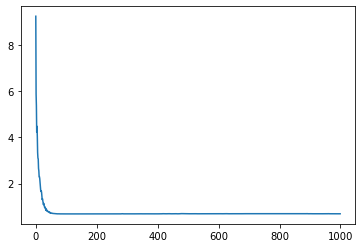

total time = 45.643306016922
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.4586       0.459      0.031
pair=[83, 144]


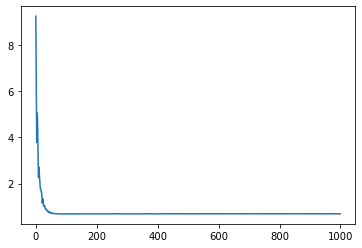

total time = 44.369750022888184
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.4658      0.4666     0.0365
pair=[25, 80]


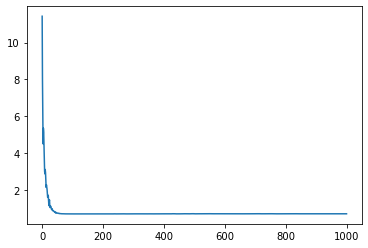

total time = 47.940606117248535
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.4851      0.4868     0.0345
pair=[43, 53]


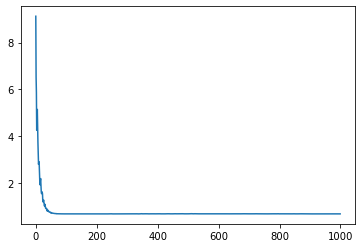

total time = 47.799959897994995
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.4026      0.4029     0.0832
pair=[12, 82]


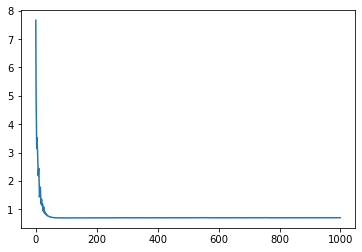

total time = 46.19591498374939
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.4962      0.4975      0.015
endpoint_errors = 
 [0.459, 0.4666, 0.4868, 0.4029, 0.4975]
endpoint_stds = 
 [0.031, 0.0365, 0.0345, 0.0832, 0.015]
average errors: 0.4626
average stds:   0.04


In [ ]:
endpoint_errors = []
endpoint_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    A = neuralNetworkClassificationCNN(Data[pair[0]], Data[pair[1]], Q_size = 20, 
                                       lr_decay = 0.9, learning_rate = 1e-2, 
                                       num_trials_maj=1, out_channels=10, kernel_size=2,  
                                       padding = 1, bias = True, Num_updates = 1000, 
                                       D_out = 2, epoch = 50, version = 'endpoints', 
                                       sigma = 10, test_size = 0.3)
    print(A[0])
    endpoint_errors.append(np.round(A[1], decimals=4).tolist())
    endpoint_stds.append(np.round(A[2], decimals=4).tolist())
    print("===========================================================================")

print('endpoint_errors = \n', endpoint_errors)
print('endpoint_stds = \n', endpoint_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(endpoint_errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(endpoint_stds), decimals=4)}', 'green'))


### Rand($v_Q$)

pair=[50, 94]


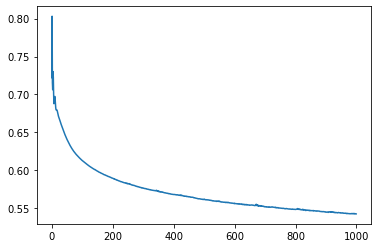

total time = 65.10119700431824
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2937      0.3641     0.0476
pair=[83, 144]


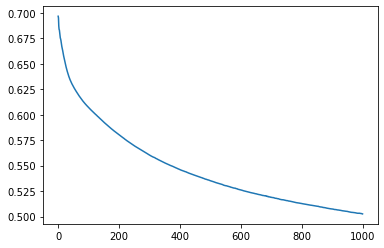

total time = 60.02845525741577
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2587      0.3362     0.0536
pair=[25, 80]


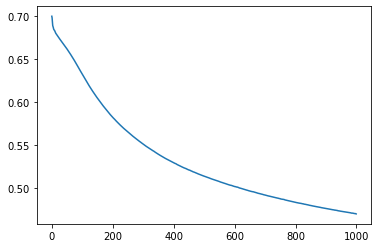

total time = 61.106404066085815
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2376      0.3484       0.04
pair=[43, 53]


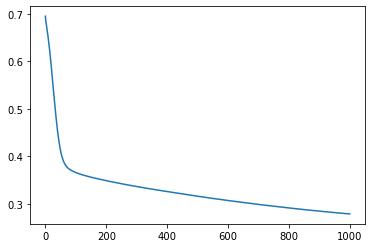

total time = 56.35661220550537
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1254      0.1834     0.0404
pair=[12, 82]


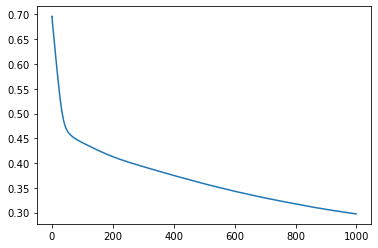

total time = 60.23509502410889
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01        0.124      0.1929     0.0434
v_Q_errors = 
 [0.3641, 0.3362, 0.3484, 0.1834, 0.1929]
v_Q_errors_stds = 
 [0.0476, 0.0536, 0.04, 0.0404, 0.0434]
average errors: 0.285
average stds:   0.045


In [ ]:
errors = []
errors_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    A = neuralNetworkClassificationCNN(Data[pair[0]], Data[pair[1]], Q_size = 20, 
                                       lr_decay = 0.9, learning_rate = 1e-2, 
                                       num_trials_maj=1, out_channels= 10, kernel_size= 5,
                                       padding = 1, bias = True, Num_updates = 1000, 
                                       D_out = 2, epoch = 50, version = 'unsigned', 
                                       sigma = 10, test_size = 0.3)
    print(A[0])
    errors.append(np.round(A[1], decimals=4).tolist())
    errors_stds.append(np.round(A[2], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_errors = \n', errors)
print('v_Q_errors_stds = \n', errors_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(errors_stds), decimals=4)}', 'green'))


### Rand($v_Q^{\varsigma}$)

pair=[50, 94]


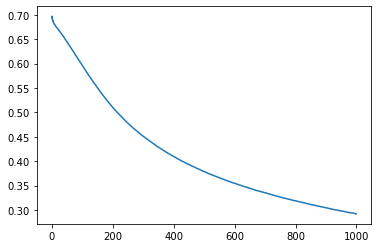

total time = 70.54496383666992
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1219      0.4633     0.0561
pair=[83, 144]


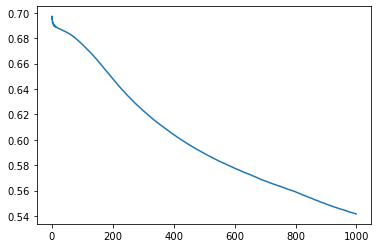

total time = 70.52855277061462
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2918      0.4329     0.0547
pair=[25, 80]


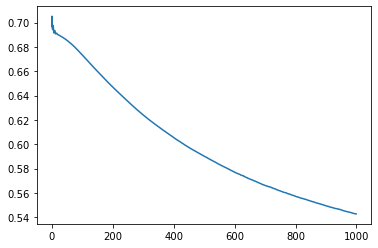

total time = 71.56008505821228
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.3001      0.4651     0.0517
pair=[43, 53]


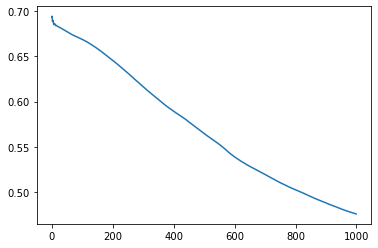

total time = 67.98701310157776
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2378      0.3609      0.076
pair=[12, 82]


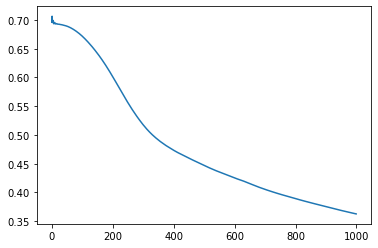

total time = 70.48362588882446
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1567       0.257     0.0445
v_Q_varsigma_errors =  [0.4633, 0.4329, 0.4651, 0.3609, 0.257]
v_Q_varsigma_errors_stds =  [0.0561, 0.0547, 0.0517, 0.076, 0.0445]
average errors: 0.3958
average stds:   0.0566
Total time:  353.6652910709381


In [ ]:
errors = []
errors_stds = []

s_time = time.time()
for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    A = neuralNetworkClassificationCNN(Data[pair[0]], Data[pair[1]], Q_size = 20, 
                                       lr_decay = 0.9, learning_rate = 1e-2, 
                                       num_trials_maj=1, out_channels= 10, kernel_size= 5,
                                       padding = 1, bias = True, Num_updates = 1000, 
                                       D_out = 2, epoch = 50, version = 'signed', 
                                       sigma = 10, test_size = 0.3)
    print(A[0])
    errors.append(np.round(A[1], decimals=4).tolist())
    errors_stds.append(np.round(A[2], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_varsigma_errors = ', errors)
print('v_Q_varsigma_errors_stds = ', errors_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(errors_stds), decimals=4)}', 'green'))

print("Total time: ", time.time() - s_time)

### Rand($v_Q^{exp}$)

pair=[50, 94]


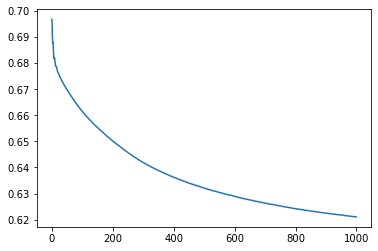

total time = 61.77073693275452
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.3989      0.4451     0.0294
pair=[83, 144]


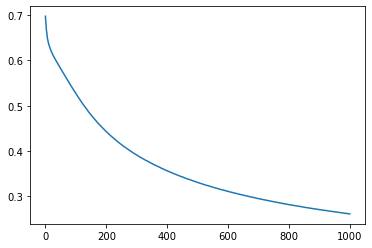

total time = 62.82014489173889
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1078       0.358     0.0503
pair=[25, 80]


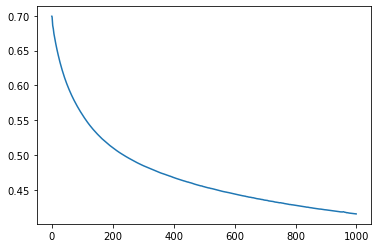

total time = 65.72552824020386
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2217      0.3795     0.0363
pair=[43, 53]


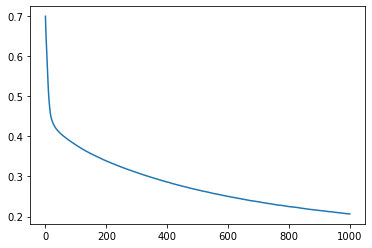

total time = 56.63902807235718
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0902        0.23     0.0373
pair=[12, 82]


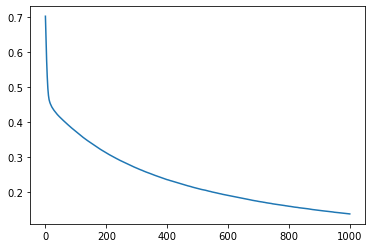

total time = 60.31300187110901
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01        0.045      0.2185     0.0403
v_Q_exp_errors = 
 [0.4451, 0.358, 0.3795, 0.23, 0.2185]
v_Q_exp_errors_stds = 
 [0.0294, 0.0503, 0.0363, 0.0373, 0.0403]
average errors: 0.3262
average stds:   0.0387


In [ ]:
errors = []
errors_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    A = neuralNetworkClassificationCNN(Data[pair[0]], Data[pair[1]], Q_size = 20, 
                                       lr_decay = 0.9, learning_rate = 1e-2, 
                                       num_trials_maj=1, out_channels= 10, kernel_size= 5,
                                       padding = 1, bias = True, Num_updates = 1000, 
                                       D_out = 2, epoch = 50, version = 'exp', 
                                       sigma = 10, test_size = 0.3)
    print(A[0])
    errors.append(np.round(A[1], decimals=4).tolist())
    errors_stds.append(np.round(A[2], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_exp_errors = \n', errors)
print('v_Q_exp_errors_stds = \n', errors_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(errors_stds), decimals=4)}', 'green'))


## num_maj = 11

### Vote($v_Q$)

pair=[50, 94]


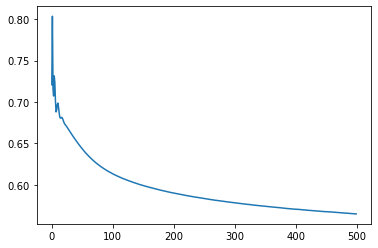

total time = 284.01261591911316
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01        0.328      0.3674     0.0486
pair=[83, 144]


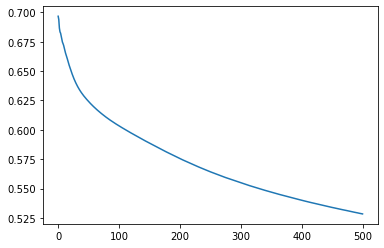

total time = 289.5458161830902
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2686       0.341     0.0413
pair=[25, 80]


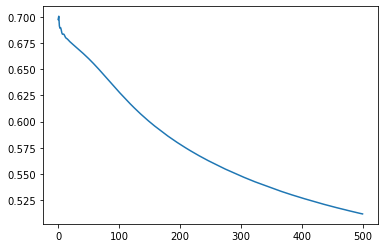

total time = 288.87901616096497
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2633      0.3446     0.0546
pair=[43, 53]


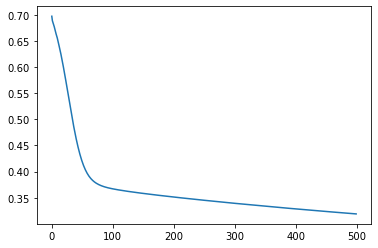

total time = 272.40068197250366
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1447      0.1763     0.0341
pair=[12, 82]


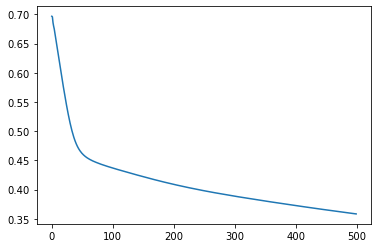

total time = 285.63289308547974
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01        0.152      0.1962     0.0396
v_Q_errors = 
 [0.3674, 0.341, 0.3446, 0.1763, 0.1962]
v_Q_errors_stds = 
 [0.0486, 0.0413, 0.0546, 0.0341, 0.0396]
average errors: 0.2851
average stds:   0.0436
Total time:  1433.5615549087524


In [ ]:
errors = []
errors_stds = []
s_time = time.time()

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    A = neuralNetworkClassificationCNN(Data[pair[0]], Data[pair[1]], Q_size = 20, 
                                       lr_decay = 0.9, learning_rate = 1e-2, 
                                       num_trials_maj=11, out_channels=10, kernel_size=5,
                                       padding = 1, bias = True, Num_updates = 500, 
                                       D_out = 2, epoch = 50, version = 'unsigned', 
                                       sigma = 10, test_size = 0.3)
    print(A[0])
    errors.append(np.round(A[1], decimals=4).tolist())
    errors_stds.append(np.round(A[2], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_errors = \n', errors)
print('v_Q_errors_stds = \n', errors_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(errors_stds), decimals=4)}', 'green'))
print("Total time: ", time.time() - s_time)

### Vote($v_Q^{\varsigma}$)

pair=[50, 94]


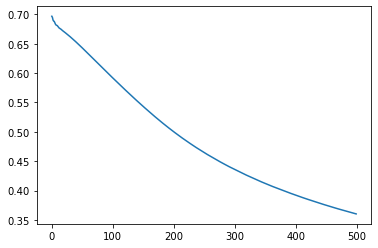

total time = 399.6591639518738
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1549      0.4687     0.0564
pair=[83, 144]


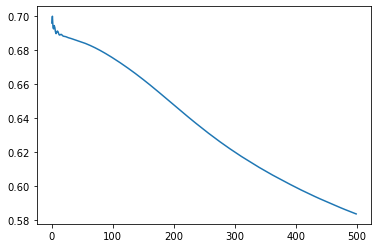

total time = 348.0148537158966
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01        0.315      0.4276     0.0555
pair=[25, 80]


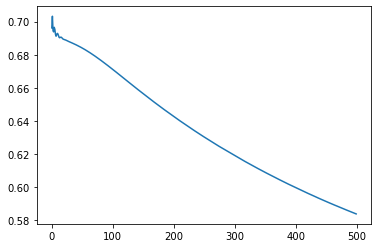

total time = 351.22157526016235
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01        0.336       0.497     0.0596
pair=[43, 53]


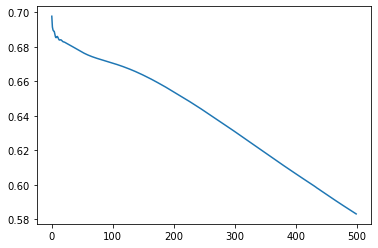

total time = 329.3962051868439
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.3037      0.3823     0.0833
pair=[12, 82]


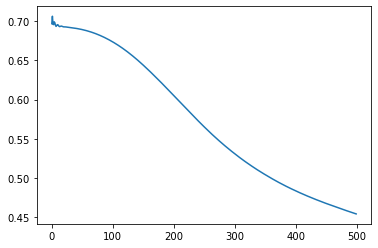

total time = 343.2651870250702
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2077      0.2671     0.0709
v_Q_varsigma_errors = 
 [0.4687, 0.4276, 0.497, 0.3823, 0.2671]
v_Q_varsigma_errors_stds = 
 [0.0564, 0.0555, 0.0596, 0.0833, 0.0709]
average errors: 0.4085
average stds:   0.0651
Total time:  1784.8751962184906


In [ ]:
errors = []
errors_stds = []
s_time = time.time()

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    A = neuralNetworkClassificationCNN(Data[pair[0]], Data[pair[1]], Q_size = 20, 
                                       lr_decay = 0.9, learning_rate = 1e-2, 
                                       num_trials_maj=11, out_channels=10, kernel_size=5,
                                       padding = 1, bias = True, Num_updates = 500, 
                                       D_out = 2, epoch = 50, version = 'signed', 
                                       sigma = 10, test_size = 0.3)
    print(A[0])
    errors.append(np.round(A[1], decimals=4).tolist())
    errors_stds.append(np.round(A[2], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_varsigma_errors = \n', errors)
print('v_Q_varsigma_errors_stds = \n', errors_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(errors_stds), decimals=4)}', 'green'))
print("Total time: ", time.time() - s_time)

### Vote($v_Q^{exp}$)

pair=[50, 94]


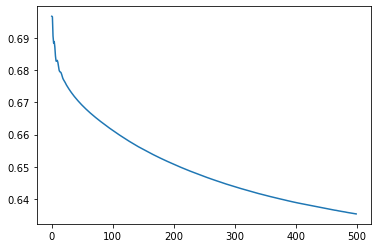

total time = 288.3674359321594
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.4034      0.4359     0.0363
pair=[83, 144]


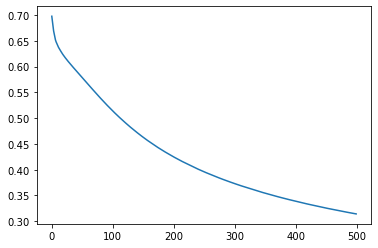

total time = 290.5321731567383
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1379      0.3435     0.0536
pair=[25, 80]


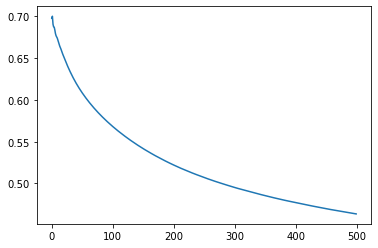

total time = 298.6893858909607
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2424      0.3739     0.0513
pair=[43, 53]


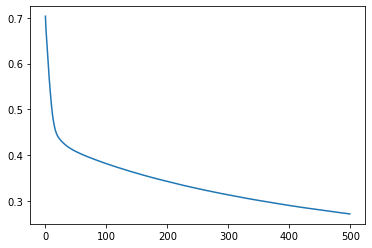

total time = 270.7680308818817
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1209      0.2171     0.0459
pair=[12, 82]


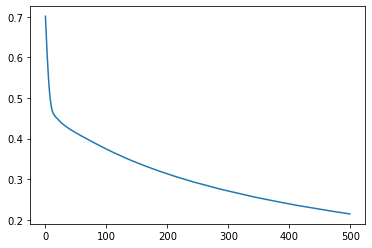

total time = 284.73483395576477
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0869      0.2078       0.04
v_Q_exp_errors = 
 [0.4359, 0.3435, 0.3739, 0.2171, 0.2078]
v_Q_exp_errors_stds = 
 [0.0363, 0.0536, 0.0513, 0.0459, 0.04]
average errors: 0.3156
average stds:   0.0454
Total time:  1448.773551940918


In [ ]:
errors = []
errors_stds = []
s_time = time.time()

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    A = neuralNetworkClassificationCNN(Data[pair[0]], Data[pair[1]], Q_size = 20, 
                                       lr_decay = 0.9, learning_rate = 1e-2, 
                                       num_trials_maj=11, out_channels=10, kernel_size=5,
                                       padding = 1, bias = True, Num_updates = 500, 
                                       D_out = 2, epoch = 50, version = 'exp', 
                                       sigma = 10, test_size = 0.3)
    print(A[0])
    errors.append(np.round(A[1], decimals=4).tolist())
    errors_stds.append(np.round(A[2], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_exp_errors = \n', errors)
print('v_Q_exp_errors_stds = \n', errors_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(errors_stds), decimals=4)}', 'green'))
print("Total time: ", time.time() - s_time)

# Neural Network for Mistake Driven Method of Choosing $Q$

## Initialize $Q$

In [ ]:
def initialize_Q(train_1, train_2, std_coeff, out_channels, kernel_size, Q_size, 
                 padding, learning_rate = 1e-3, bias = True, D_out=2, lr_decay = 0.9, 
                 Num_updates = 100): 
        
    Q = []
    errors = []
    losses = np.zeros((Q_size - kernel_size, Num_updates))
    
    mu = get_mu(train_1, train_2)
    std = mu * std_coeff

    trajectory_train_data = np.concatenate((train_1, train_2), axis = 0)
    train_labels = np.concatenate(([1] * len(train_1), [0] * len(train_2)), 0)
    train_labels = torch.from_numpy(train_labels).long()
    index = np.random.randint(0, high=len(trajectory_train_data)) 
    k = np.random.randint(0, high=len(trajectory_train_data[index]))
    for i in range(kernel_size):
        q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
        Q.append(q)

    for i in range(Q_size - kernel_size):
        train_data = ExpCurve2Vec(np.array(Q), trajectory_train_data, mu)
        model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                            out_channels = out_channels, 
                            kernel_size = kernel_size,
                            stride  = 1,
                            padding = padding,
                            bias = bias),
                nn.ReLU(),
                #nn.LeakyReLU(0.01),
                #nn.Tanh(),
                Flatten(),
                nn.Linear(out_channels * (len(train_data[0]) - kernel_size + 1 + 2 * padding), 
                            D_out)
                )
    
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        
        train_data = torch.from_numpy(train_data).float()
        train_data = train_data.view(len(train_data), 1, len(train_data[0]))
        
        for k in range(Num_updates):
            x_pred = model(train_data) # of shape (N, D_out)
            loss = loss_fn(x_pred, train_labels)
            losses[i, k] = loss
            
            if (k+1) % 100 == 0:
                optimizer.param_groups[0]['lr'] = lr_decay * learning_rate
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 
        
        train_pred = torch.argmax(model(train_data), axis=1)
        scores = model(train_data)
        I = np.where((train_labels == train_pred) == False)[0]

        temp_labels = 2 * train_labels.numpy().reshape(len(train_labels.numpy()), 1) - 1
        temp = temp_labels * scores.detach().numpy()
        temp = np.max(temp, axis=1)
        index = I[np.argmax(temp[I])]

        error = sum(train_labels != train_pred)/len(train_labels)
        errors.append(error.item())
        
        k = np.random.randint(0, high=len(trajectory_train_data[index]))
        q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
        Q.append(q)

    final_error = errors[-1]

    #plt.plot((np.mean(losses, axis=0)))
    #plt.show()

    return np.array(Q), np.array(errors), mu, final_error


## MD_CNN

In [ ]:
def MD_NeuralNetworkClassificationCNN(data_1, data_2, maj_num, epoch, init_iter, 
                                      test_size, std_coeff, out_channels, kernel_size, 
                                      Q_size, padding, learning_rate = 1e-3, 
                                      bias = True, D_out=2, lr_decay = 0.9, 
                                      Num_updates = 100):
        
    start_time = time.time()

    train_errors = np.zeros(epoch) 
    test_errors = np.zeros(epoch)

    n_1 = len(data_1)
    n_2 = len(data_2) 

    for s in range(epoch):
        train_idx_1, test_idx_1, train_label_1, test_label_1, train_idx_2, \
        test_idx_2, train_label_2, test_label_2 = train_test(data_1, data_2, test_size)

        train = np.concatenate((data_1[train_idx_1], data_2[train_idx_2]), 0)
        test = np.concatenate((data_1[test_idx_1], data_2[test_idx_2]), 0)
        train_labels = np.concatenate((train_label_1, train_label_2), axis = 0)
        test_labels = np.concatenate((test_label_1, test_label_2), axis = 0)
        train_labels = torch.from_numpy(train_labels).long()
        test_labels = torch.from_numpy(test_labels).long()

        x_preds = torch.zeros((maj_num, len(train)))
        y_preds = torch.zeros((maj_num, len(test)))
        
        I = np.arange(len(train))
        np.random.shuffle(I)
        train = train[I]
        train_labels = train_labels[I]
        
        J = np.arange(len(test))
        np.random.shuffle(J)
        test = test[J]
        test_labels = test_labels[J]

        for t in range(maj_num):

            Q_list = []
            temp_errors = []
            mu_temp = []

            for j in range(init_iter):
                B = initialize_Q(data_1[train_idx_1], data_2[train_idx_2], 
                                 std_coeff, out_channels, kernel_size, Q_size, 
                                 padding, learning_rate = 1e-3, bias = True, 
                                 D_out=2, lr_decay = 0.9, Num_updates = 100)

                Q_list.append(B[0])
                mu_temp.append(B[2])
                temp_errors.append(B[-1])

            h = np.argmin(temp_errors)
            Q = Q_list[h]
            mu = mu_temp[h]

            train_data = torch.from_numpy(ExpCurve2Vec(Q, train, mu)).float()
            train_data = train_data.view(len(train_data), 1, len(train_data[0]))

            test_data = torch.from_numpy(ExpCurve2Vec(Q, test, mu)).float()
            test_data = test_data.view(len(test_data), 1, len(test_data[0]))

            model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                                    out_channels = out_channels, 
                                    kernel_size = kernel_size,
                                    stride  = 1,
                                    padding = padding,
                                    bias = bias),
                    nn.ReLU(),
                    #nn.LeakyReLU(0.01),
                    #nn.Tanh(),
                    Flatten(),
                    nn.Linear(out_channels * (len(train_data[0][0]) - kernel_size + 1 + 2 * padding), 
                              D_out)
                    )
        
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        
            for k in range(Num_updates):
                x_pred = model(train_data) # of shape (N, D_out)
                loss = loss_fn(x_pred, train_labels)

                if (k+1) % 10 == 0:
                    optimizer.param_groups[0]['lr'] = lr_decay * learning_rate
                optimizer.zero_grad()
                loss.backward() 
                optimizer.step() 

            scores = model(train_data)
            
            x_preds[t] = torch.argmax(scores, axis=1)
            y_preds[t] = torch.argmax(model(test_data), axis=1)

        x_preds = torch.tensor(find_majority_array(x_preds))
        y_preds = torch.tensor(find_majority_array(y_preds))

        train_errors[s] = sum(abs(train_labels - x_preds))/len(train_labels)
        test_errors[s] = sum(abs(test_labels - y_preds))/len(test_labels)

    train_error_mean = np.mean(train_errors)
    test_error_mean = np.mean(test_errors)
    test_error_std = np.std(test_errors)

    Dict = {"CNN 1-Layer": [out_channels, learning_rate, 
                            np.round(train_error_mean, decimals = 4), 
                            np.round(test_error_mean, decimals = 4),
                            np.round(test_error_std, decimals = 4)]}

    pdf = pd.DataFrame.from_dict(Dict, orient='index', 
                                 columns=['Channel 1', 'Learning Rate', 
                                          'Train Error', 'Test Error', 'Std Error'])

    print(colored(f"total time = {time.time() - start_time}", "red"))
    print("mu =", mu)

    return pdf, test_error_mean, test_error_std


### num_maj = 1

In [ ]:
errors = []
errors_stds = []

s_time = time.time()
for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    A = MD_NeuralNetworkClassificationCNN(Data[pair[0]], Data[pair[1]], maj_num=1, 
                                          epoch=50, init_iter=3, 
                                          test_size=0.3, std_coeff=1, out_channels=10, 
                                          kernel_size = 5, Q_size = 20, padding = 1, 
                                          learning_rate = 1e-2, bias = True, D_out=2, 
                                          lr_decay = 0.9, Num_updates = 1000)
    print(A[0])
    errors.append(np.round(A[1], decimals=4).tolist())
    errors_stds.append(np.round(A[2], decimals=4).tolist())
    print("===========================================================================")

print('errors = ', errors)
print('errors_stds = ', errors_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(errors_stds), decimals=4)}', 'green'))

print("Total time: ", time.time() - s_time)


pair=[50, 94]


../aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


total time = 316.3809988498688
mu = 0.03717698249194257
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0877      0.3933     0.0483
pair=[83, 144]
total time = 298.91283106803894
mu = 0.09555440002303328
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0919      0.3529     0.0475
pair=[25, 80]
total time = 318.36062002182007
mu = 0.09049965151578476
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1915      0.3704     0.0574
pair=[43, 53]
total time = 278.83002185821533
mu = 0.10908119179471498
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0438       0.228     0.0501
pair=[12, 82]
total time = 298.3630669116974
mu = 0.08177054244823978
             Channel 1  Learning Rate  Train Error  Test Error  Std 

### num_maj = 11

In [ ]:
MD_errors = []
MD_errors_stds = []

In [ ]:
s_time = time.time()
pair = pairs_final[0]
print(colored(f"pair={pair}", 'green'))
A = MD_NeuralNetworkClassificationCNN(Data[pair[0]], Data[pair[1]], maj_num=11, epoch=50, 
                                      init_iter=3, test_size=0.3, std_coeff=1, 
                                      out_channels=10, kernel_size = 5, Q_size = 20, 
                                      padding = 1, learning_rate = 1e-2, bias = True, 
                                      D_out=2, lr_decay = 0.9, Num_updates = 1000)
print(A[0])
MD_errors.append(np.round(A[1], decimals=4).tolist())
MD_errors_stds.append(np.round(A[2], decimals=4).tolist())
print("time: ", time.time() - s_time)

pair=[50, 94]
total time = 3152.3346631526947
mu = 0.03777982293889437
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0814      0.3823       0.06
time:  3152.3380510807037


In [ ]:
s_time = time.time()
pair = pairs_final[1]
print(colored(f"pair={pair}", 'green'))
A = MD_NeuralNetworkClassificationCNN(Data[pair[0]], Data[pair[1]], maj_num=11, epoch=50, 
                                      init_iter=3, test_size=0.3, std_coeff=1, 
                                      out_channels=10, kernel_size = 5, Q_size = 20, 
                                      padding = 1, learning_rate = 1e-2, bias = True, 
                                      D_out=2, lr_decay = 0.9, Num_updates = 1000)
print(A[0])
MD_errors.append(np.round(A[1], decimals=4).tolist())
MD_errors_stds.append(np.round(A[2], decimals=4).tolist())
print("time: ", time.time() - s_time)

pair=[83, 144]
total time = 3288.6273460388184
mu = 0.09024342728370982
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0848      0.3354     0.0455
time:  3288.6305639743805


In [ ]:
s_time = time.time()
pair = pairs_final[2]
print(colored(f"pair={pair}", 'green'))
A = MD_NeuralNetworkClassificationCNN(Data[pair[0]], Data[pair[1]], maj_num=11, epoch=50, 
                                      init_iter=3, test_size=0.3, std_coeff=1, 
                                      out_channels=10, kernel_size = 5, Q_size = 20, 
                                      padding = 1, learning_rate = 1e-2, bias = True, 
                                      D_out=2, lr_decay = 0.9, Num_updates = 1000)
print(A[0])
MD_errors.append(np.round(A[1], decimals=4).tolist())
MD_errors_stds.append(np.round(A[2], decimals=4).tolist())
print("time: ", time.time() - s_time)

pair=[25, 80]
total time = 3480.1728208065033
mu = 0.10931585761201745
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1591      0.3623     0.0523
time:  3480.1764059066772


In [ ]:
s_time = time.time()
pair = pairs_final[3]
print(colored(f"pair={pair}", 'green'))
A = MD_NeuralNetworkClassificationCNN(Data[pair[0]], Data[pair[1]], maj_num=11, epoch=50, 
                                      init_iter=3, test_size=0.3, std_coeff=1, 
                                      out_channels=10, kernel_size = 5, Q_size = 20, 
                                      padding = 1, learning_rate = 1e-2, bias = True, 
                                      D_out=2, lr_decay = 0.9, Num_updates = 1000)
print(A[0])
MD_errors.append(np.round(A[1], decimals=4).tolist())
MD_errors_stds.append(np.round(A[2], decimals=4).tolist())
print("time: ", time.time() - s_time)

pair=[43, 53]
total time = 3200.31614112854
mu = 0.1031322421441061
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0412      0.2157     0.0408
time:  3200.3196868896484


In [ ]:
s_time = time.time()
pair = pairs_final[4]
print(colored(f"pair={pair}", 'green'))
A = MD_NeuralNetworkClassificationCNN(Data[pair[0]], Data[pair[1]], maj_num=11, epoch=50, 
                                      init_iter=3, test_size=0.3, std_coeff=1, 
                                      out_channels=10, kernel_size = 5, Q_size = 20, 
                                      padding = 1, learning_rate = 1e-2, bias = True, 
                                      D_out=2, lr_decay = 0.9, Num_updates = 1000)
print(A[0])
MD_errors.append(np.round(A[1], decimals=4).tolist())
MD_errors_stds.append(np.round(A[2], decimals=4).tolist())
print("time: ", time.time() - s_time)

pair=[12, 82]
total time = 3716.661080121994
mu = 0.09032064810671159
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0391      0.2144     0.0476
time:  3716.664315223694


In [ ]:
print('errors = ', MD_errors)
print('errors_stds = ', MD_errors_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(MD_errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(MD_errors_stds), decimals=4)}', 'green'))


errors =  [0.3823, 0.3354, 0.3623, 0.2157, 0.2144]
errors_stds =  [0.06, 0.0455, 0.0523, 0.0408, 0.0476]
average errors: 0.302
average stds:   0.0492


# Plot test errors

In [ ]:
A_LSVM = [0.2864, 0.2920, 0.4900, 0.3303, 0.2911, 0.2948, 0.4944, 0.3273, 0.3701]
A_GSVM = [0.2894, 0.2857, 0.3796, 0.3137, 0.2975, 0.2893, 0.3979, 0.3154, 0.3032]
A_PSVM = [0.2767, 0.2906, 0.4467, 0.3267, 0.2953, 0.3001, 0.4577, 0.3308, 0.3357]
A_DT = [0.2760, 0.2890, 0.3440, 0.3095, 0.3179, 0.3200, 0.3857, 0.3343, 0.3316]
A_RF = [0.2710, 0.2764, 0.3266, 0.3036, 0.2711, 0.2885, 0.3417, 0.3072, 0.2943]
A_KNN = [0.2898, 0.2868, 0.3942, 0.2923, 0.2929, 0.2943, 0.4028, 0.3082, 0.2944]
A_LR = [0.2923, 0.3361, 0.4609, 0.3308, 0.3029, 0.3381, 0.4615, 0.3341, 0.3959]
A_CNN = [0.3020, 0.2851, 0.4085, 0.3156, 0.3098, 0.2850, 0.3958, 0.3262, 0.4626]

A = np.array([A_LSVM, A_GSVM, A_PSVM, A_DT, A_RF, A_KNN, A_LR, A_CNN])
B = A.T

In [ ]:
std_LSVM = [0.0418, 0.0416, 0.0489, 0.0460, 0.0426, 0.0414, 0.0518, 0.0510, 0.0461]
std_GSVM = [0.0458, 0.0400, 0.0486, 0.0406, 0.0448, 0.0393, 0.0519, 0.0478, 0.0420]
std_PSVM = [0.0440, 0.0405, 0.0456, 0.0411, 0.0463, 0.0404, 0.0493, 0.0457, 0.0404]
std_DT = [0.0433, 0.0470, 0.0474, 0.0423, 0.0475, 0.0465, 0.0533, 0.0477, 0.0480]
std_RF = [0.0430, 0.0434, 0.0485, 0.0410, 0.0392, 0.0410, 0.0485, 0.0394, 0.0450]
std_KNN = [0.0426, 0.0435, 0.0490, 0.0430, 0.0446, 0.0446, 0.0485, 0.0471, 0.0421]
std_LR = [0.0373, 0.0418, 0.0075, 0.0353, 0.0415, 0.0467, 0.0110, 0.0424, 0.0363]
std_CNN = [0.0492, 0.0436, 0.0651, 0.0454, 0.0492, 0.0450, 0.0566, 0.0387, 0.0400]

C = np.array([std_LSVM, std_GSVM, std_PSVM, std_DT, std_RF, std_KNN, std_LR, std_CNN]).T

In [ ]:
errors = [0.2967, 0.3038, 0.2912, 0.2947, 0.2860, 0.2830, 0.2847, 0.2726, 0.5140, 
          0.3550, 0.3607, 0.2864]

stds = [0.0383, 0.0424, 0.0453, 0.0430, 0.0397, 0.0404, 0.0397, 0.0415, 0.0415, 
        0.0498, 0.0564, 0.0433]

In [ ]:
classifiers = ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR', 'CNN']

FM = (r'KNN', r'Vote(MD $v_Q^{exp}$)', r'Vote(Rand $v_Q$)', r'Vote($v_Q^{\varsigma}$)', 
      r'Vote(Rand $v_Q^{exp}$)', r'MD $v_Q^{exp}$', r'Rand $v_Q$', 
      r'Rand $v_Q^{\varsigma}$', r'Rand $v_Q^{exp}$', 'Endpoints')

labels = ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR', 'CNN']

dists = [r'$d_F$', r'$d_{dF}$', r'$dH$', r'DTW', r'soft-dtw', r'fastdtw', 
         r'LCSS', r'SSPD', r'EDR', r'ERP', r'LSH', r'$d_Q^{\pi}$']

In [ ]:
def lower_limit_error(x, y):
    if y - x < 0:
        return y
    else:
        return x

lower_limit_error = np.vectorize(lower_limit_error)

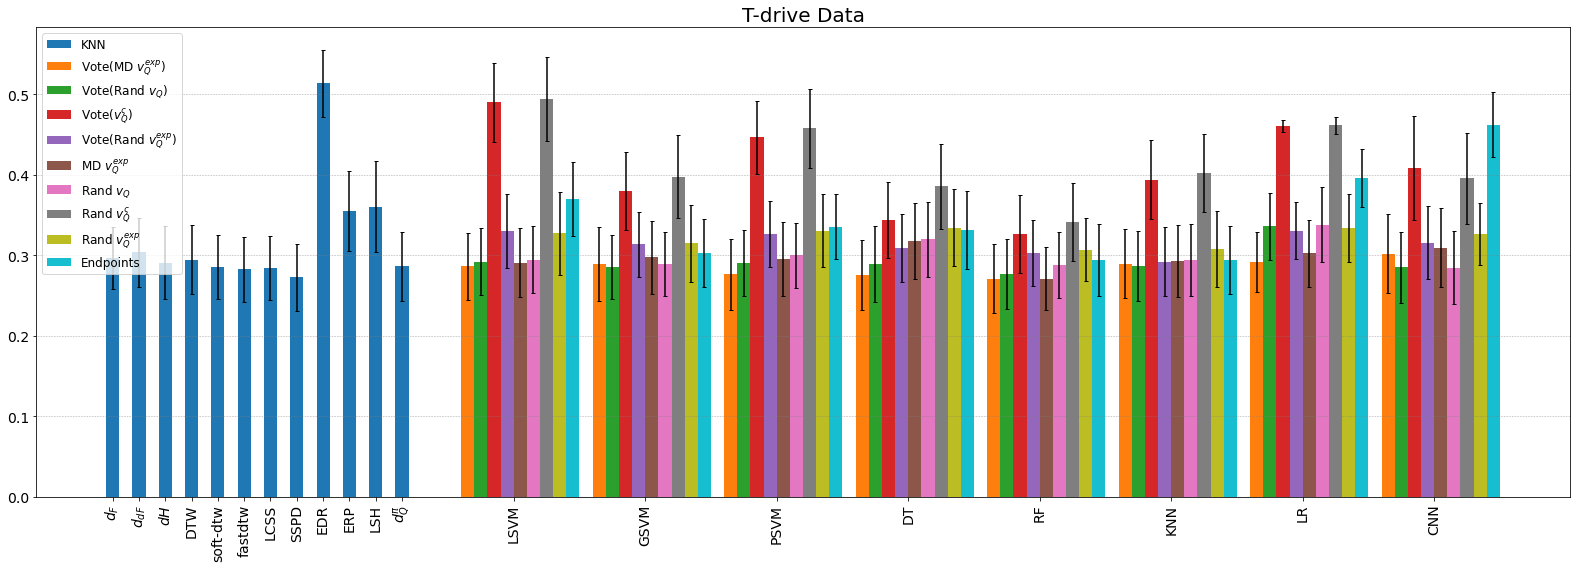

In [ ]:
width=0.1
index = np.arange(len(stds))
ind = np.arange(len(A)) + len(index) * 0.25

plt.subplots(figsize = (22, 8), tight_layout=True)
bars = [0] * 10

lower_lim = lower_limit_error(stds, errors)
bars[0] = plt.bar(index * 0.2, errors, width, yerr=[lower_lim, stds], capsize=2)

for i in range(len(FM)-1):
    lower_limit = lower_limit_error(C[i], B[i])
    bars[i+1] = plt.bar(ind+width*i-0.3, B[i], width, yerr=[lower_limit, C[i]], capsize=2)

plt.title('T-drive Data', fontsize = 20)
plt.xticks(list(np.arange(len(stds)) * 0.2) + list(ind + 0.5 * width), 
           dists + labels, fontsize = 14)

plt.legend(tuple(bars), FM, loc=2, fontsize = 12)

plt.gca().yaxis.grid(color='gray', linestyle='dotted', linewidth=0.6)
plt.xticks(rotation='vertical', fontsize = 14)
plt.yticks(fontsize = 14)

plt.savefig('/Users/hasan/Desktop/plots/plots T-drive/T-drive bar chart all horizontal.png', 
            bbox_inches='tight', dpi=200)

plt.show()
